# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,mean_squared_error


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('azdias structure', np.shape(azdias))
print('feat_info', np.shape(azdias))


azdias structure (891221, 85)
feat_info (891221, 85)


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:

feat_info_n = copy.deepcopy(feat_info)
feat_info_n=feat_info_n.drop(['information_level','type'],axis=1) #created new data frame to be able to pla with cleaning


In [11]:
feat_info_n['missing_or_unknown_']=feat_info_n['missing_or_unknown'] #new column for modification
feat_info_n.head()

,attribute,missing_or_unknown,missing_or_unknown_
0,AGER_TYP,"[-1,0]","[-1,0]"
1,ALTERSKATEGORIE_GROB,"[-1,0,9]","[-1,0,9]"
2,ANREDE_KZ,"[-1,0]","[-1,0]"
3,CJT_GESAMTTYP,[0],[0]
4,FINANZ_MINIMALIST,[-1],[-1]


In [12]:

for s in range(np.shape(feat_info_n)[0]):
    #print(len(str(feat_info_n['missing_or_unknown'][s])))
    if(len(str(feat_info_n['missing_or_unknown'][s]))==2):   #no clean out needed is 2 character []
        feat_info_n['missing_or_unknown_'][s]='pass'
        #print("['pass']")
    else:
        
        snew=str(feat_info_n['missing_or_unknown'][s]).replace('[','').replace(']','').split(',')    #get the values in real list
        #print(snew)
        feat_info_n['missing_or_unknown_'][s]=snew
                
       

In [13]:
feat_info_n['missing_or_unknown_'].tail(20)

65    [-1, 0]
66       [-1]
67       [-1]
68       [-1]
69       pass
70    [-1, 0]
71       pass
72       pass
73    [-1, 0]
74       pass
75       [-1]
76       [-1]
77       [-1]
78       [-1]
79    [-1, 0]
80       [-1]
81       [-1]
82    [-1, 9]
83    [-1, 0]
84    [-1, 9]
Name: missing_or_unknown_, dtype: object

In [14]:
feat_info_n=feat_info_n.drop(['missing_or_unknown'],axis=1) #created new data frame to be able to play with cleaning
feat_info_n.head()

,attribute,missing_or_unknown_
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0, 9]"
2,ANREDE_KZ,"[-1, 0]"
3,CJT_GESAMTTYP,[0]
4,FINANZ_MINIMALIST,[-1]


In [15]:
column_='GFK_URLAUBERTYP'

feat_info_n[feat_info_n['attribute']==column_]['missing_or_unknown_'].values[0]!='pass'

False

In [16]:
#import copy
azdias_ = copy.deepcopy(azdias)


In [17]:
#replace unknown/missing with Nan

for i,column_ in enumerate(azdias_.columns):
    if(i<86):
        missing_attr=feat_info_n[feat_info_n['attribute']==column_]['missing_or_unknown_'].values[0]
        if(missing_attr!='pass'):
            for j in range(len(missing_attr)):
                try:
                    azdias_.loc[azdias_[column_]==int(missing_attr[j]),column_]=np.nan
                except:
                    print(column_)
                    azdias_.loc[azdias_[column_]=='X',column_]=np.nan
                    azdias_.loc[azdias_[column_]=='XX',column_]=np.nan
    


CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015


In [18]:
#record of missing values for each feature column

missing_column_percent=[]
missing_count=[]

for i,column_ in enumerate(azdias_.columns):
    print(i,column_,'       ',azdias_[column_].isnull().sum(),azdias_[column_].isnull().sum()*100/np.shape(azdias_)[0])
    missing_column_percent.append(azdias_[column_].isnull().sum()*100/np.shape(azdias_)[0])
    missing_count.append(azdias_[column_].isnull().sum())
    #azdias[column_].isnull().sum()
    
    
#use estimatd age instead of best ager typology 1 instead of 0
#drop GEBURTSJAHR, since 44% miss, have column1 instead
#grop TITEL_KZ dr, prof useless mostly empty
#ALTER_HH 43, use 1
#KK_KUNDENTYP  65% miss, need replacement  #RETOURTYP_BK_S w/ instead

#AGER_TYP   77%
#GEBURTSJAHR  44%
#TITEL_KZ     99%
#ALTER_HH    34.8%
#KK_KUNDENTYP  65%
#KBA05_BAUMAX   53

0 AGER_TYP         685843 76.9554352961
1 ALTERSKATEGORIE_GROB         2881 0.323264375503
2 ANREDE_KZ         0 0.0
3 CJT_GESAMTTYP         4854 0.544646052999
4 FINANZ_MINIMALIST         0 0.0
5 FINANZ_SPARER         0 0.0
6 FINANZ_VORSORGER         0 0.0
7 FINANZ_ANLEGER         0 0.0
8 FINANZ_UNAUFFAELLIGER         0 0.0
9 FINANZ_HAUSBAUER         0 0.0
10 FINANZTYP         0 0.0
11 GEBURTSJAHR         392318 44.0202822869
12 GFK_URLAUBERTYP         4854 0.544646052999
13 GREEN_AVANTGARDE         0 0.0
14 HEALTH_TYP         111196 12.4768155149
15 LP_LEBENSPHASE_FEIN         97632 10.9548585592
16 LP_LEBENSPHASE_GROB         94572 10.6115093787
17 LP_FAMILIE_FEIN         77792 8.72869916665
18 LP_FAMILIE_GROB         77792 8.72869916665
19 LP_STATUS_FEIN         4854 0.544646052999
20 LP_STATUS_GROB         4854 0.544646052999
21 NATIONALITAET_KZ         108315 12.1535511394
22 PRAEGENDE_JUGENDJAHRE         108164 12.1366080916
23 RETOURTYP_BK_S         4854 0.544646052999
24 SEMIO

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)


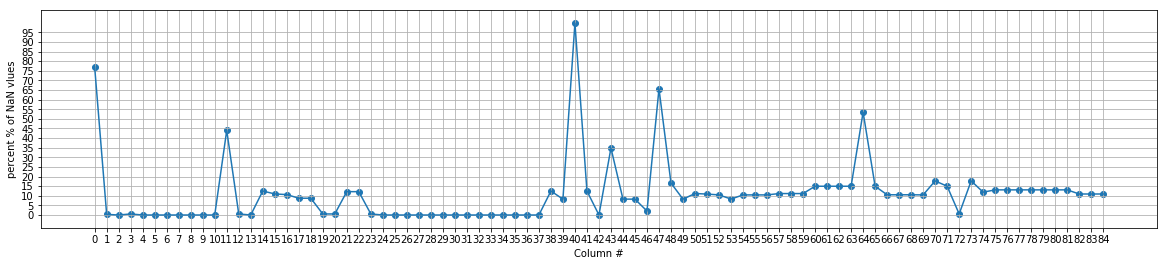

In [179]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.figure(figsize=(20,4))
plt.plot(np.arange(0,85,1),missing_column_percent)
plt.scatter(np.arange(0,85,1),missing_column_percent)
plt.xticks(np.arange(0, 85, step=1))
plt.yticks(np.arange(0, 100, step=5))
plt.xlabel('Column #')
plt.ylabel('percent % of NaN vlues')
plt.grid(True)
plt.show()
#plt.hist(missing_count,bins=85)
#azdias_.columns

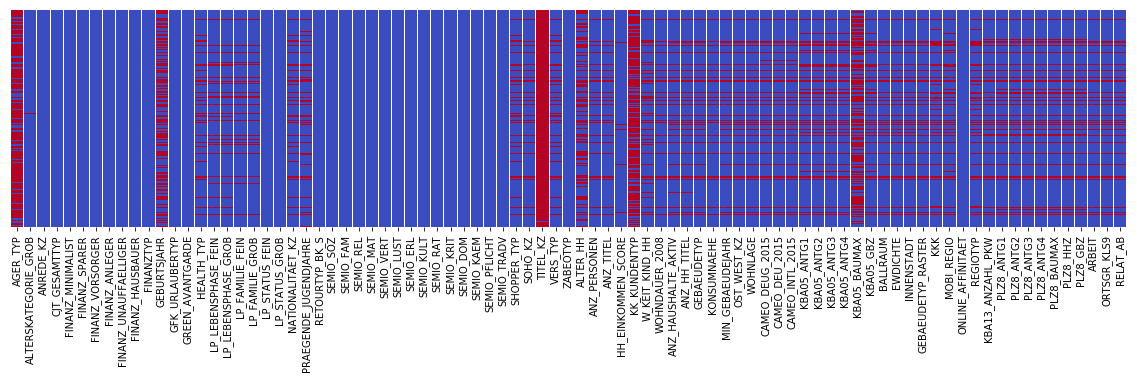

In [19]:
plt.figure(figsize=(20,4))
sns.heatmap(azdias_.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_out_remove = copy.deepcopy(azdias_)
azdias_out_remove=azdias_out_remove.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)

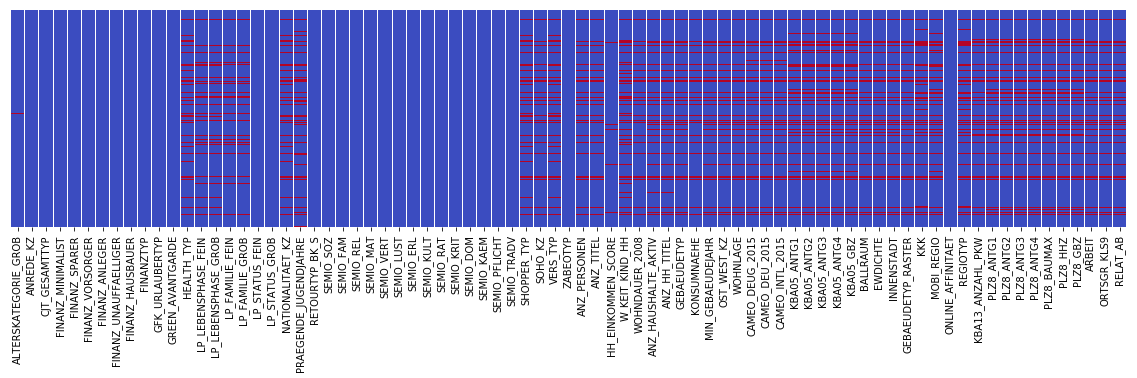

In [120]:
#after removing 6 outlier coumns
plt.figure(figsize=(20,4))
sns.heatmap(azdias_out_remove.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

In [20]:
azdias_out_remove.to_csv('azadis_col_out_r.csv',index=False)    #write a copy to file

In [219]:
# azdias_out_remove_n = pd.read_csv('azadis_col_out_r.csv')

In [220]:
# azdias_out_remove_n.head()

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

There are 6 columns that are more critical to remove with above 34% missing. The 99% belong to the tile, then age bracket. whether or not new cutomer,The 34% belong to birthday of head of houshold (ALTER_HH), since there are other columns with less missing data that represent age groups ALTER_HH is removed.

-AGER_TYP   77%<br>
-GEBURTSJAHR  44%<br>
-TITEL_KZ     99%<br>
-ALTER_HH    34.8%<br>
-KK_KUNDENTYP  65%<br>
-KBA05_BAUMAX   53%

#remove 6 columns above with >~35% missings.

Some other columns that show missing data between 0 to ~15% , show similar trend across rows. Those are shopper info, micro/macro cell features PR3/PR4, building features, and household features have similar missing trend, as well as house hold "LP" information. It is possible the they were collected initially in similar batches of survey/database.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [32]:
# How much data is missing in each row of the dataset?

#Up to 47 missing per row is observed

row_missing=azdias_out_remove.isnull().sum(axis=1).tolist()

In [33]:
# a column with added missing number per row is created 

azdias_out_remove['count_row_miss']=azdias_out_remove.isnull().sum(axis=1)

In [34]:
azdias_out_remove.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,count_row_miss
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [35]:
azdias_no_miss=azdias_out_remove[azdias_out_remove['count_row_miss']==0]

In [35]:
azdias_with_miss=azdias_out_remove[azdias_out_remove['count_row_miss']!=0]

In [38]:
np.shape(azdias_no_miss)[0]*100/np.shape(azdias_out_remove)[0]   #70% percent of clean data (no outlier column or row)

69.9275488346886

Text(0.5,0,'number of missing values')

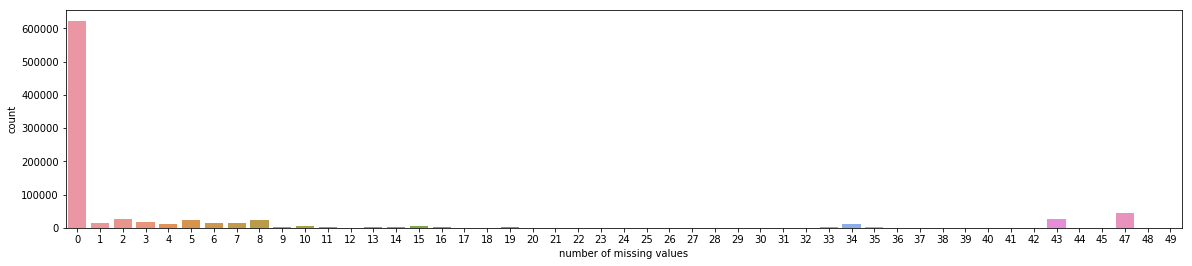

In [44]:
#Up to 47 missing per row is observed
plt.figure(figsize=(20,4))
sns.countplot(row_missing)
plt.xlabel('number of missing values')

In [55]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#azdias_no_miss
#azdias_with_miss

def compare_clean_miss_datasets(df1_clean,df2_notclean,column_name):
    
    plt.figure(figsize=(10,10))
    plt.subplot(2, 1, 1)
    sns.countplot(df1_clean[column_name])
    plt.title('Clean data column  %s' %(column_name))
    plt.ylabel('Count')

    plt.subplot(2, 1, 2)
    sns.countplot(df2_notclean[column_name])
    plt.title('Missing data column  %s' %(column_name))
    plt.ylabel('Count')
    
    
    

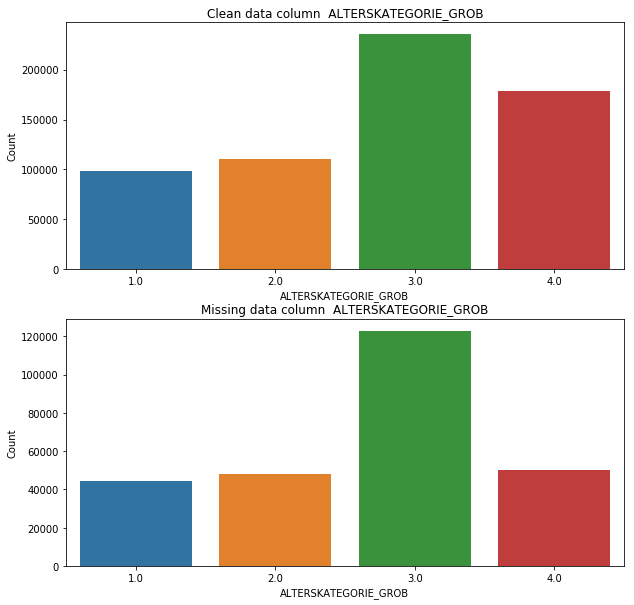

In [56]:
compare_clean_miss_datasets(azdias_no_miss,azdias_with_miss,'ALTERSKATEGORIE_GROB')

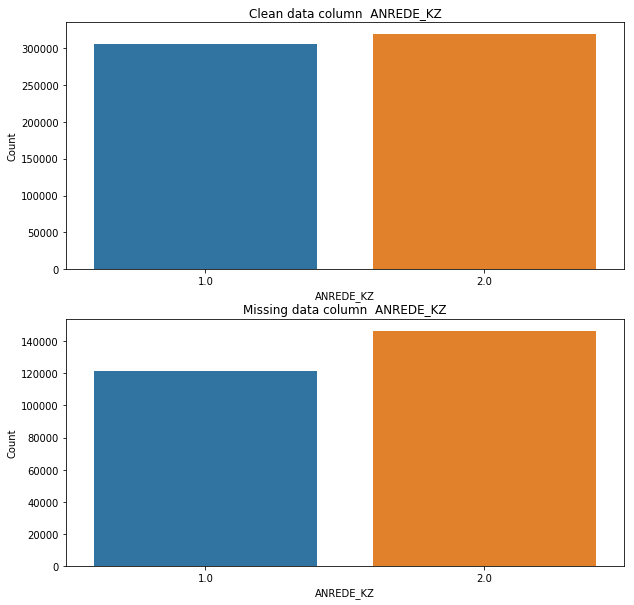

In [57]:
compare_clean_miss_datasets(azdias_no_miss,azdias_with_miss,'ANREDE_KZ')

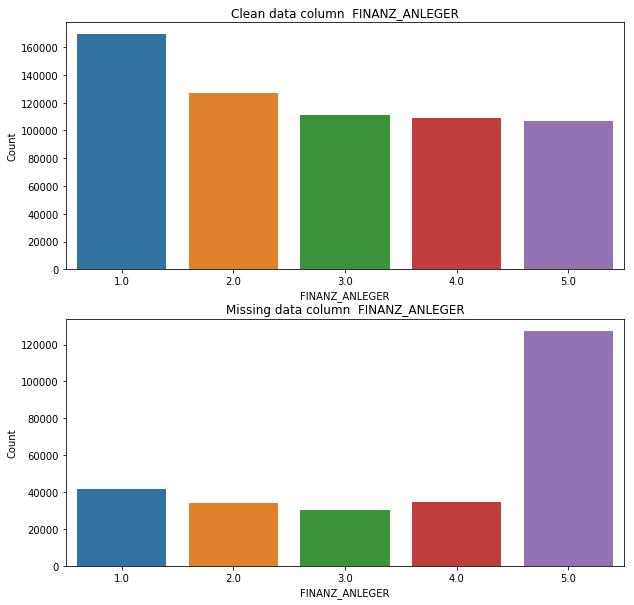

In [58]:
compare_clean_miss_datasets(azdias_no_miss,azdias_with_miss,'FINANZ_ANLEGER')

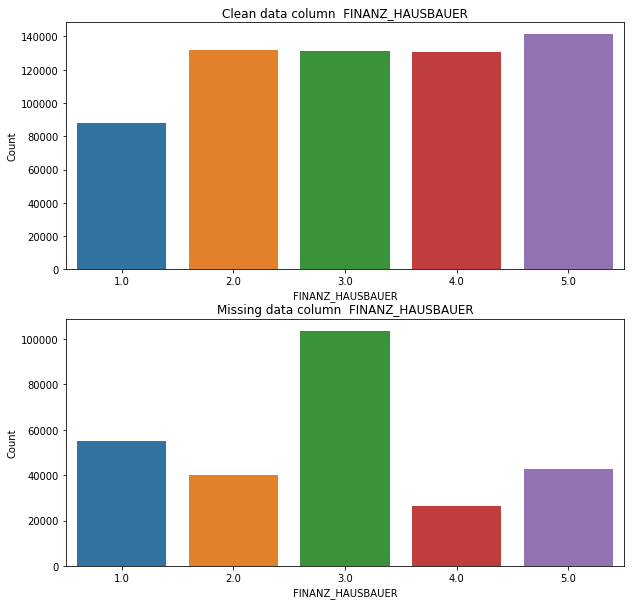

In [60]:
compare_clean_miss_datasets(azdias_no_miss,azdias_with_miss,'FINANZ_HAUSBAUER')

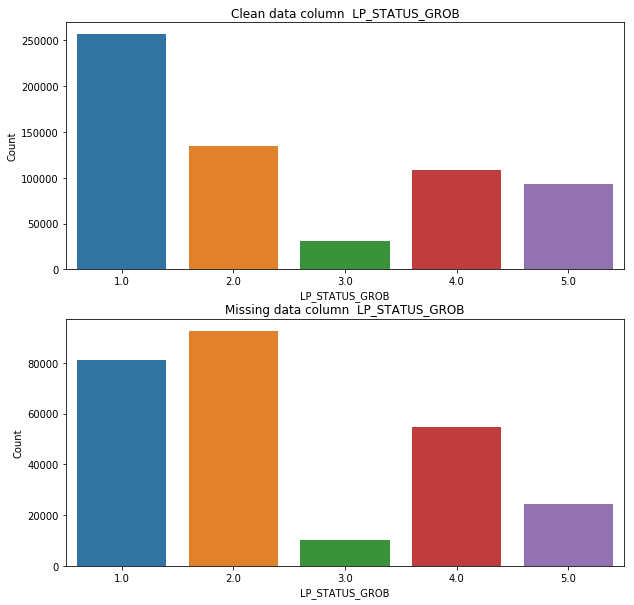

In [61]:
compare_clean_miss_datasets(azdias_no_miss,azdias_with_miss,'LP_STATUS_GROB')

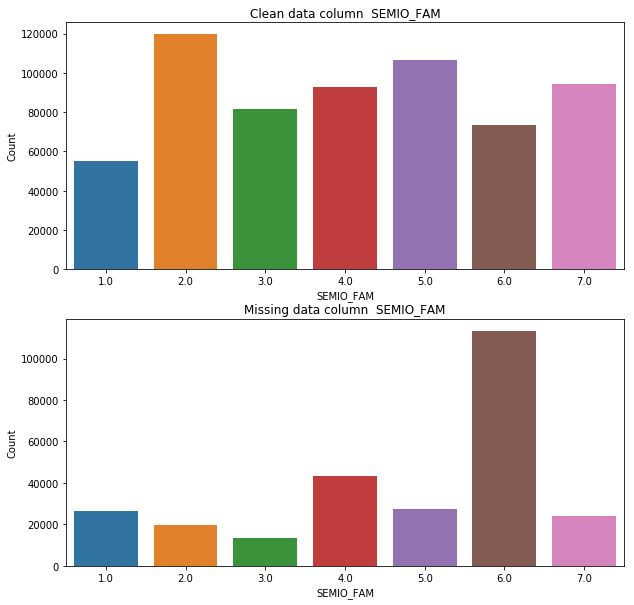

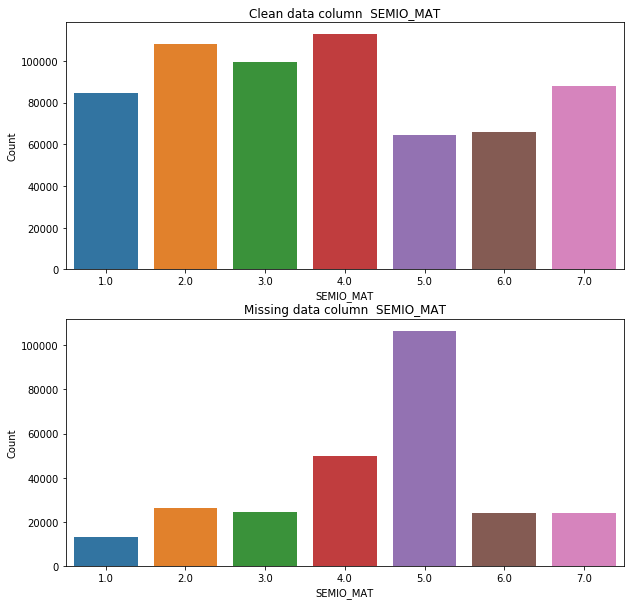

In [62]:
compare_clean_miss_datasets(azdias_no_miss,azdias_with_miss,'SEMIO_FAM')
compare_clean_miss_datasets(azdias_no_miss,azdias_with_miss,'SEMIO_MAT')

In [21]:
azdias_no_miss=azdias_out_remove.dropna()

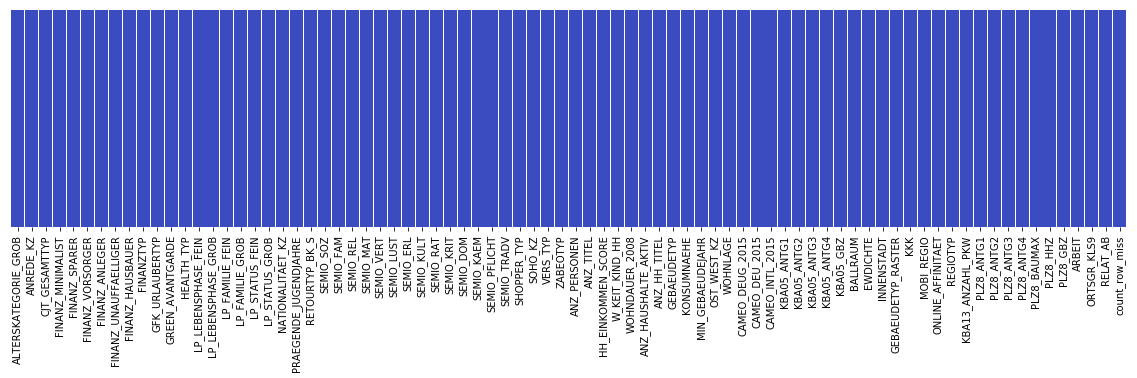

In [36]:
plt.figure(figsize=(20,4))
sns.heatmap(azdias_no_miss.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

In [22]:
azdias_out_remove.shape

(891221, 79)

In [23]:
azdias_no_miss.shape

(623209, 79)

In [24]:
azdias_no_miss.isnull().sum().sum()   #no missing data

0

In [38]:
azdias_no_miss=azdias_no_miss.drop(['count_row_miss'],axis=1)

In [39]:
azdias_no_miss.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,1.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2.0,1.0,2.0,2.0,5.0,3.0,1.0,5.0,6.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0
19,3.0,1.0,3.0,5.0,2.0,3.0,1.0,3.0,1.0,5.0,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,4.0,6.0,3.0


In [25]:
azdias_no_miss.to_csv('azdias_no_miss_data.csv',index=False)    #save clean data

In [3]:
azdias_no_miss=pd.read_csv('azdias_no_miss_data.csv')

In [4]:
azdias_no_miss.isnull().sum().sum()

0

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)


With regard to age, gender and some general attributes, the clean_data and data with missing rows are very similar, however in term of shopping power, finances and their approach toward shopping (e.g. being materialistic or not) the two sets are different. Therefore, only plan to use the clean data with no missing at all, this set has a bigger population 70% of the data, and also considering distribution of finance data being different do not think it is appropriate to replace any of those missing (with mode of distribution). Since this may impact the trend just for the sake of having more data. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [5]:
# How many features are there of each data type?

feat_info.head()

feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [163]:
feat_info['type'].unique()[4]

'interval'

In [6]:
feat_info[feat_info['type']=='interval']   #this is dropped already for high count of null

,attribute,information_level,type,missing_or_unknown
43,ALTER_HH,household,interval,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [182]:
#azdias_no_miss

oridinal_numeric_col=feat_info[(feat_info['type']=='ordinal') | (feat_info['type']=='numeric')]['attribute'].values

oridinal_numeric_col

array(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'GEBURTSJAHR', 'HEALTH_TYP', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB'], dtype=object)

In [7]:
#AGER_TYP   77%   cat out
#GEBURTSJAHR  44%  numeric out
#TITEL_KZ     99%  cat out
#ALTER_HH    34.8% *interval not even included since drop at beginning
#KK_KUNDENTYP  65% cat out
#KBA05_BAUMAX   53%   mix out

#removed below cols not adding info, mostly constant, std very low
# ANZ_PERSONEN   Number of adults in household  num   *
# ANZ_TITEL  Number of professional academic title holders in household num   *
# ANZ_HAUSHALTE_AKTIV Number of households in the building   num *
# ANZ_HH_TITEL Number of professional academic title holders in building num *
# MIN_GEBAEUDEJAHR First year building was mentioned in the database num *

#numerical data are kept are below:

azdias_no_miss_num_keep=pd.DataFrame(azdias_no_miss[['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008',
       'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']])

In [12]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_col=feat_info[feat_info['type']=='categorical']['attribute'].values
categorical_col
#AGER_TYP alreay dropped
#ANREDE


array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [10]:
azdias_no_miss['ANREDE_KZ'].nunique()   #count if binary 2

2

In [11]:
list(azdias_no_miss['ANREDE_KZ'].value_counts().index)

[2.0, 1.0]

In [13]:

for col_ in categorical_col:
    try:
        print(col_,sorted(list(azdias_no_miss[col_].value_counts().index)))
    except:
        pass
#columns that are not already removed in cleaning    
    
#ANREDE_KZ          keep   male, female            binary
#CJT_GESAMTTYP      keep   advertising             multi
#FINANZTYP          keep   financial, income       multi
#GFK_URLAUBERTYP    keep   habit/hobby             multi
#GREEN_AVANTGARDE   keep   sustainability          binary
#LP_FAMILIE_FEIN    drop*   fine family category    multi
#LP_FAMILIE_GROB    keep   coarse family category  multi
#LP_FAMILIE_FEIN    drop*   fine scale Social status multi
#LP_STATUS_GROB     keep   coarse scale Social status multi
#NATIONALITAET_KZ   keep   nationality!               multi
#SHOPPER_TYP        keep   Shopper type               multi
#SOHO_KZ            keep   home office or not        binary
#VERS_TYP           keep  insurance                  binary
#ZABEOTYP           keep   energy consumption        multi
#GEBAEUDETYP        keep   residential building     multi
#OST_WEST_KZ        keep   east vs. west           binary    
#CAMEO_DEUG_2015    keep   wealth                  multi
#CAMEO_DEU_2015     drop*  detail wealth          multi

#dropped value did not have info about shopping or were too detailed where the coarse version of the same data was available and kept

ANREDE_KZ [1.0, 2.0]
CJT_GESAMTTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
FINANZTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
GFK_URLAUBERTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
GREEN_AVANTGARDE [0, 1]
LP_FAMILIE_FEIN [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
LP_FAMILIE_GROB [1.0, 2.0, 3.0, 4.0, 5.0]
LP_STATUS_FEIN [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
LP_STATUS_GROB [1.0, 2.0, 3.0, 4.0, 5.0]
NATIONALITAET_KZ [1.0, 2.0, 3.0]
SHOPPER_TYP [0.0, 1.0, 2.0, 3.0]
SOHO_KZ [0.0, 1.0]
VERS_TYP [1.0, 2.0]
ZABEOTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
GEBAEUDETYP [1.0, 3.0, 5.0, 8.0]
OST_WEST_KZ ['O', 'W']
CAMEO_DEUG_2015 [1, 2, 3, 4, 5, 6, 7, 8, 9]
CAMEO_DEU_2015 ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E']


In [15]:
#kept majority of categorical values unless they were redundant in terms of info (group vs detailed)
azdias_no_miss_cat_keep=pd.DataFrame(azdias_no_miss[['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'LP_FAMILIE_GROB', 
       'NATIONALITAET_KZ', 'SHOPPER_TYP',  
       'VERS_TYP', 'ZABEOTYP', 
       'OST_WEST_KZ','CAMEO_DEUG_2015',  'LP_STATUS_GROB']])  #decided to drop , 'GEBAEUDETYP' (std issue), 'SOHO_KZ' (std issue), drop since constant mess range after scaler transorm

In [16]:
azdias_no_miss_cat_keep.isnull().sum()

ANREDE_KZ           0
CJT_GESAMTTYP       0
FINANZTYP           0
GFK_URLAUBERTYP     0
GREEN_AVANTGARDE    0
LP_FAMILIE_GROB     0
NATIONALITAET_KZ    0
SHOPPER_TYP         0
VERS_TYP            0
ZABEOTYP            0
OST_WEST_KZ         0
CAMEO_DEUG_2015     0
LP_STATUS_GROB      0
dtype: int64

In [17]:

azdias_no_miss_cat_keep['OST_WEST_KZ'].value_counts()

W    490879
O    132330
Name: OST_WEST_KZ, dtype: int64

In [18]:
#to replace 'W' and 'O', West/East germany as a integer to encode
azdias_no_miss_cat_keep.loc[azdias_no_miss_cat_keep['OST_WEST_KZ']=='O','OST_WEST_KZ']=0.0
azdias_no_miss_cat_keep.loc[azdias_no_miss_cat_keep['OST_WEST_KZ']=='W','OST_WEST_KZ']=1.0


In [19]:
azdias_no_miss_cat_keep['OST_WEST_KZ'].value_counts()

1.0    490879
0.0    132330
Name: OST_WEST_KZ, dtype: int64

In [99]:
azdias_no_miss_cat_keep.columns

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015',
       'LP_STATUS_GROB'],
      dtype='object')

In [20]:


categorical_col_keep=azdias_no_miss_cat_keep.columns


column_name_cat=[]    #make the list for column title after onehotencoding, shows unique value to be added as prefix
for col_ in categorical_col_keep:
    try:
        list_value_sort=sorted(list(azdias_no_miss_cat_keep[col_].value_counts().index))
        len_=len(list_value_sort)
        #print(col_,list(azdias_no_miss_cat_keep[col_].value_counts().index))
        print(col_,list_value_sort,len_)
        for i in range(len_):
            column_name_cat.append(str(col_)+'_'+str(int(list_value_sort[i])))
            
            
    except:
        pass
    
    #52 total expected from onehotencode

ANREDE_KZ [1.0, 2.0] 2
CJT_GESAMTTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 6
FINANZTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 6
GFK_URLAUBERTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0] 12
GREEN_AVANTGARDE [0, 1] 2
LP_FAMILIE_GROB [1.0, 2.0, 3.0, 4.0, 5.0] 5
NATIONALITAET_KZ [1.0, 2.0, 3.0] 3
SHOPPER_TYP [0.0, 1.0, 2.0, 3.0] 4
VERS_TYP [1.0, 2.0] 2
ZABEOTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 6
OST_WEST_KZ [0.0, 1.0] 2
CAMEO_DEUG_2015 [1, 2, 3, 4, 5, 6, 7, 8, 9] 9
LP_STATUS_GROB [1.0, 2.0, 3.0, 4.0, 5.0] 5


In [27]:
len(column_name_cat)

64

In [28]:
# Re-encode categorical variable(s) to be kept in the analysis. I chose to include binary in nature variable here as well for consistency
# for example male/female, East/West
from sklearn.preprocessing import OneHotEncoder

encode_ = OneHotEncoder()  #sparse=False if True return sparse, if false an array

azdias_no_miss_cat_keep_encode=encode_.fit_transform(azdias_no_miss_cat_keep)

In [29]:
#import pickle

#pickle onehotcoder just in case
filename_ = 'onehotcode_model.sav'
pickle.dump(encode_, open(filename_, 'wb'))
 


In [30]:
#column_name_cat   #np.arange(0,70,1)

# make dataframe from categorical to check the table
azdias_no_miss_cat_keep_encode_df=pd.DataFrame(azdias_no_miss_cat_keep_encode.toarray(),columns=column_name_cat)

In [31]:
#data frama categorical before onehot coding
azdias_no_miss_cat_keep.head(10)

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_GROB,NATIONALITAET_KZ,SHOPPER_TYP,VERS_TYP,ZABEOTYP,OST_WEST_KZ,CAMEO_DEUG_2015,LP_STATUS_GROB
0,2.0,5.0,1.0,10.0,0,3.0,1.0,3.0,2.0,5.0,1,8,1.0
1,2.0,3.0,1.0,10.0,1,1.0,1.0,2.0,1.0,5.0,1,4,2.0
2,1.0,5.0,5.0,5.0,0,5.0,1.0,2.0,2.0,4.0,1,6,2.0
3,2.0,2.0,2.0,1.0,0,1.0,1.0,0.0,2.0,4.0,1,8,2.0
4,2.0,5.0,4.0,12.0,0,1.0,1.0,1.0,1.0,4.0,1,4,1.0
5,1.0,3.0,5.0,9.0,0,1.0,1.0,0.0,1.0,1.0,1,2,1.0
6,1.0,3.0,6.0,3.0,1,1.0,1.0,3.0,2.0,6.0,1,1,5.0
7,2.0,4.0,1.0,12.0,1,1.0,1.0,3.0,2.0,4.0,1,1,2.0
8,2.0,1.0,6.0,8.0,0,1.0,1.0,2.0,2.0,3.0,1,9,1.0
9,1.0,3.0,5.0,8.0,1,2.0,1.0,2.0,2.0,2.0,1,5,5.0


In [32]:
#data frame categorical after onehot coding
azdias_no_miss_cat_keep_encode_df.head(10)

,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,FINANZTYP_1,FINANZTYP_2,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,LP_STATUS_GROB_4,LP_STATUS_GROB_5
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
type(azdias_no_miss_cat_keep_encode_df)

pandas.core.frame.DataFrame

In [34]:
azdias_no_miss_cat_keep_encode_df.isnull().sum().sum()

0

In [68]:
azdias_no_miss_cat_keep_encode.toarray()[0:10,0:10]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [69]:
encode_.feature_indices_

array([ 0,  3, 10, 17, 30, 32, 38, 42, 46, 49, 56, 58, 68, 74, 83])

In [70]:
np.shape(azdias_no_miss_cat_keep_encode)

(623209, 68)

In [71]:
encode_.active_features_

array([ 1,  2,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39,
       40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 75, 77, 79, 82])

In [72]:
#azdias_no_miss_cat_keep_encode_frame=pd.DataFrame([pd.SparseSeries(azdias_no_miss_cat_keep_encode[i].toarray().ravel()) for i in np.arange(azdias_no_miss_cat_keep_encode.shape[0])])

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

As many column as possible were kept. majority of ordinal/numerical columns are kept. for categorical column that were redundant dropped, e.g. if group data was available fine data was dropped. e.g. LP_STATUS_FEIN vs LP_FAMILIE_GROB, LP_FAMILIE_FEIN vs LP_FAMILIE_GROB, CAMEO_DEU_2015 vs. CAMEO_DEUG_2015. Binary data are one hot coded as muti component categorical for consistency, and less hassle.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [179]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

### 1.18. PRAEGENDE_JUGENDJAHRE
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# - -1: unknown
# -  0: unknown                                                            Main_avant              decade_life
# -  1: 40s - war years (Mainstream, E+W)                                     1-40-0                  0
# -  2: 40s - reconstruction years (Avantgarde, E+W)                          2-40-0                  1
# -  3: 50s - economic miracle (Mainstream, E+W)                              3-50-1                  0
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)                  4-50-1                  1
# -  5: 60s - economic miracle (Mainstream, E+W)                              5-60-2                  0
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)              6-60-2                  1
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)           7-60-2                  1
# -  8: 70s - family orientation (Mainstream, E+W)                            8-70-3                  0
# -  9: 70s - peace movement (Avantgarde, E+W)                                9-70-3                  1
# - 10: 80s - Generation Golf (Mainstream, W)                                10-80-4                  0
# - 11: 80s - ecological awareness (Avantgarde, W)                           11-80-4                  1
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)       12-80-4                  0
# - 13: 80s - Swords into ploughshares (Avantgarde, E)                       13-80-4                  1
# - 14: 90s - digital media kids (Mainstream, E+W)                           14-90-5                  0
# - 15: 90s - ecological awareness (Avantgarde, E+W)                         15-90-5                  1

In [35]:
# keep only 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015' for mixed
azdias_no_miss_mix_keep=pd.DataFrame(azdias_no_miss[['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']])

In [36]:
azdias_no_miss.isnull().sum().sum()

0

In [37]:
azdias_no_miss_mix_keep.isnull().sum().sum()

0

In [38]:
azdias_no_miss_mix_keep.head()

,PRAEGENDE_JUGENDJAHRE,CAMEO_INTL_2015
0,14.0,51
1,15.0,24
2,8.0,43
3,3.0,54
4,10.0,22


In [39]:
azdias_no_miss_mix_keep[azdias_no_miss_mix_keep['PRAEGENDE_JUGENDJAHRE']==np.nan]

,PRAEGENDE_JUGENDJAHRE,CAMEO_INTL_2015


In [40]:
azdias_no_miss_mix_keep.isnull().sum()

PRAEGENDE_JUGENDJAHRE    0
CAMEO_INTL_2015          0
dtype: int64

In [41]:
#azdias_no_miss_mix_keep['PRAEGENDE_JUGENDJAHRE'].value_counts()

#create dictionary for conversion of mixed columns

dic_decade={1.0:0.0, 2.0:0.0, 3.0:1.0, 4.0:1.0, 5.0:2.0, 6.0:2.0, 7.0:2.0, 8.0:3.0, 9.0:3.0, 10.0:4.0, 11.0:4.0, 12.0:4.0, 13.0:4.0, 14.0:5.0, 15.0:5.0}
dic_movement={1.0:0.0, 2.0:1.0, 3.0:0.0, 4.0:1.0, 5.0:0.0, 6.0:1.0, 7.0:1.0, 8.0:0.0, 9.0:1.0, 10.0:0.0, 11.0:1.0, 12.0:0.0, 13.0:1.0, 14.0:0.0, 15.0:1.0}

temp_=azdias_no_miss_mix_keep['PRAEGENDE_JUGENDJAHRE']

for k_,v_ in dic_decade.items():
    azdias_no_miss_mix_keep.loc[round(temp_,1)==round(k_,1),'youth_decade']=round(v_,1)
    
for k_,v_ in dic_movement.items():
    azdias_no_miss_mix_keep.loc[round(temp_,1)==round(k_,1),'youth_movement']=round(v_,1)

In [42]:
azdias_no_miss_mix_keep['CAMEO_wealth']=azdias_no_miss_mix_keep['CAMEO_INTL_2015'].apply(lambda x: round(float(x)/10,0))
azdias_no_miss_mix_keep['CAMEO_family']=azdias_no_miss_mix_keep['CAMEO_INTL_2015'].apply(lambda x: float(float(x)%10))

In [43]:
azdias_no_miss_mix_keep.head()

,PRAEGENDE_JUGENDJAHRE,CAMEO_INTL_2015,youth_decade,youth_movement,CAMEO_wealth,CAMEO_family
0,14.0,51,5.0,0.0,5.0,1.0
1,15.0,24,5.0,1.0,2.0,4.0
2,8.0,43,3.0,0.0,4.0,3.0
3,3.0,54,1.0,0.0,5.0,4.0
4,10.0,22,4.0,0.0,2.0,2.0


In [215]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
# German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown

In [44]:
azdias_no_miss_mix_keep.head()

,PRAEGENDE_JUGENDJAHRE,CAMEO_INTL_2015,youth_decade,youth_movement,CAMEO_wealth,CAMEO_family
0,14.0,51,5.0,0.0,5.0,1.0
1,15.0,24,5.0,1.0,2.0,4.0
2,8.0,43,3.0,0.0,4.0,3.0
3,3.0,54,1.0,0.0,5.0,4.0
4,10.0,22,4.0,0.0,2.0,2.0


In [45]:
azdias_no_miss_mix_keep.isnull().sum().sum()

0

In [46]:
# after 4 extra column creation, original ones are dropped
azdias_no_miss_mix_keep_encode=azdias_no_miss_mix_keep.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1)

In [47]:
azdias_no_miss_mix_keep_encode.head()

,youth_decade,youth_movement,CAMEO_wealth,CAMEO_family
0,5.0,0.0,5.0,1.0
1,5.0,1.0,2.0,4.0
2,3.0,0.0,4.0,3.0
3,1.0,0.0,5.0,4.0
4,4.0,0.0,2.0,2.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Among all mixed variable PRAEGENDE_JUGENDJAHRE, and CAMEO_INTL_2015 are kept. For PRAEGENDE_JUGENDJAHRE decade is separated as youth_decade (higher value younger), and youth_movement (main stream or avantgard). For CAMEO_INTL_2015 wealth as divided using first digit (higher more poor) and cameo_wealth. Also CAMEO_family is second digit "age/maturity" of household, with higher number meaning older households.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# 57 numeric   (two null drop)  55 kept
# 21 categorical  (3 drop by null+ 3 drop by redundacy, 3due to customer data issue => 12)   encode to 52
# 7 mix  (1 drop as null, 5 other drop => 2)   encode to 4     

#129 column
print(azdias_no_miss_num_keep.shape,            #numeric
azdias_no_miss_cat_keep_encode_df.shape, #encoded categorical to numeric
azdias_no_miss_mix_keep_encode.shape)   #mix data encoded

(623209, 50) (623209, 64) (623209, 4)


In [49]:
# no missing
azdias_no_miss_num_keep.isnull().sum().sum()

0

In [50]:
azdias_no_miss_cat_keep_encode_df.isnull().sum().sum()

0

In [52]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#create one data frame from numeric/categorical_encoded/mixed_encoded

azdias_no_miss_encoded_new=pd.concat([azdias_no_miss_num_keep,azdias_no_miss_cat_keep_encode_df,azdias_no_miss_mix_keep_encode], axis=1)

In [53]:
azdias_no_miss_encoded_new.shape

(623209, 118)

In [54]:
azdias_no_miss_encoded_new.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEUG_2015_9,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,LP_STATUS_GROB_4,LP_STATUS_GROB_5,youth_decade,youth_movement,CAMEO_wealth,CAMEO_family
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0
1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,2.0,4.0
2,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,4.0,3.0
3,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0,4.0
4,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,4.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0


In [55]:
azdias_no_miss_encoded_new.isnull().sum().sum()

0

In [135]:
azdias_no_miss_encoded_new.to_csv('azdias_no_miss_encoded.csv',index=False)   #write to file


In [72]:
azdias_no_miss_encoded_new=pd.read_csv('azdias_no_miss_encoded.csv')

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

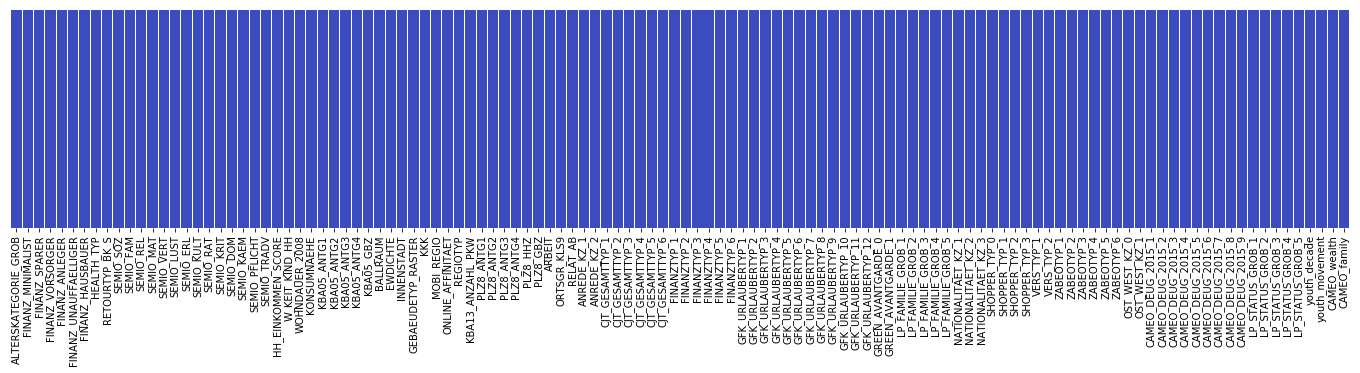

In [145]:
#encoded azadias data
plt.figure(figsize=(24,4))
sns.heatmap(azdias_no_miss_encoded_new.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

In [146]:
azdias_no_miss_encoded_new.shape

(623209, 118)

In [73]:
print(azdias_no_miss_encoded_new.isnull().sum().sum())


0


In [60]:
#cleaning function for customer data

def customer_clean_encode(customer,feature__customer):
    
    customer=customer
    feature_=feature__customer

    feature__n = copy.deepcopy(feature_)
    feature__n=feature__n.drop(['information_level','type'],axis=1) #created new data frame to be able to pla with cleaning
    feature__n['missing_or_unknown_']=feature__n['missing_or_unknown']
    # get the splitted encode
    for s in range(np.shape(feature__n)[0]):
        #print(len(str(feature__n['missing_or_unknown'][s])))
        if(len(str(feature__n['missing_or_unknown'][s]))==2):   #no clean out needed is 2 character []
            feature__n['missing_or_unknown_'][s]='pass'
            #print("['pass']")
        else:

            snew=str(feature__n['missing_or_unknown'][s]).replace('[','').replace(']','').split(',')    #get the values in real list
            #print(snew)
            feature__n['missing_or_unknown_'][s]=snew

    feature__n=feature__n.drop(['missing_or_unknown'],axis=1) #drop extra col

    customer_ = copy.deepcopy(customer)

    print('start converting to nan')
    for i,column_ in enumerate(customer_.columns):
        if(i<86):
            missing_attr=feature__n[feature__n['attribute']==column_]['missing_or_unknown_'].values[0]
            if(missing_attr!='pass'):
                for j in range(len(missing_attr)):
                    try:
                        customer_.loc[customer_[column_]==int(missing_attr[j]),column_]=np.nan
                    except:
                        print(column_)
                        customer_.loc[customer_[column_]=='X',column_]=np.nan
                        customer_.loc[customer_[column_]=='XX',column_]=np.nan

    print('finish converting to nan')
    #drop the columns with outlier data that was evident from original data
    customer_out_remove = copy.deepcopy(customer_)
    print('drop outliers col')
    customer_out_remove=customer_out_remove.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)

    print('drop outliers row')
    customer_no_miss=customer_out_remove.dropna()

    print('write no miss data to file')
    #customer_no_miss.to_csv('customer_no_miss_data.csv',index=False) 

    #get useful numeric columns
    print('make separate df of numeric col only')
    customer_no_miss_num_keep=pd.DataFrame(customer_no_miss[['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008',
       'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']])
    
    #removed since moslt constant
#     ANZ_PERSONEN   Number of adults in household  num
#     ANZ_TITEL  Number of professional academic title holders in household num
#     ANZ_HAUSHALTE_AKTIV Number of households in the building   num
#     ANZ_HH_TITEL Number of professional academic title holders in building num
#     MIN_GEBAEUDEJAHR First year building was mentioned in the database num

    #get useful categorical columns
    print('make separate df of categorical col only')

    customer_no_miss_cat_keep=pd.DataFrame(customer_no_miss[['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
           'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
           'LP_FAMILIE_GROB',
           'NATIONALITAET_KZ', 'SHOPPER_TYP', 
           'VERS_TYP', 'ZABEOTYP',
           'OST_WEST_KZ','CAMEO_DEUG_2015',  'LP_STATUS_GROB']])
    #SOHO KZ remove mostly constant
    # , 'GEBAEUDETYP' std
    
    print('write separate categorical file to csv')
    #customer_no_miss_cat_keep.to_csv('customer_no_miss_categorical.csv',index=False) 

    #letter to numeric category
    print('translate W/O')
    customer_no_miss_cat_keep.loc[customer_no_miss_cat_keep['OST_WEST_KZ']=='O','OST_WEST_KZ']=0.0
    customer_no_miss_cat_keep.loc[customer_no_miss_cat_keep['OST_WEST_KZ']=='W','OST_WEST_KZ']=1.0

    categorical_col_keep=customer_no_miss_cat_keep.columns


    #create the column name for encoded data
    print('make one hot col list')
    column_name_cat=[]
    for col_ in categorical_col_keep:
        try:
            print('try',col_)
            list_value_sort=sorted(list(customer_no_miss_cat_keep[col_].value_counts().index))
            len_=len(list_value_sort)
            #print(col_,list(customer_no_miss_cat_keep[col_].value_counts().index))
            print(col_,list_value_sort,len_)
            for i in range(len_):
                column_name_cat.append(str(col_)+'_'+str(int(list_value_sort[i])))


        except:
            print('except',col_)
            pass
    print('make one hot coding')
    
    encode__ = OneHotEncoder()  #sparse=False if True return sparse, if false an array

    customer_no_miss_cat_keep_encode=encode__.fit_transform(customer_no_miss_cat_keep)

    print('make separate df of categorical after one hot code')
    customer_no_miss_cat_keep_encode_df=pd.DataFrame(customer_no_miss_cat_keep_encode.toarray(),columns=column_name_cat)

    #get useful mix columns

    print('make separate df of mix')
    customer_no_miss_mix_keep=pd.DataFrame(customer_no_miss[['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']])

    #translation dictionary

    dic_decade={1.0:0.0, 2.0:0.0, 3.0:1.0, 4.0:1.0, 5.0:2.0, 6.0:2.0, 7.0:2.0, 8.0:3.0, 9.0:3.0, 10.0:4.0, 11.0:4.0, 12.0:4.0, 13.0:4.0, 14.0:5.0, 15.0:5.0}
    dic_movement={1.0:0.0, 2.0:1.0, 3.0:0.0, 4.0:1.0, 5.0:0.0, 6.0:1.0, 7.0:1.0, 8.0:0.0, 9.0:1.0, 10.0:0.0, 11.0:1.0, 12.0:0.0, 13.0:1.0, 14.0:0.0, 15.0:1.0}

    temp_=customer_no_miss_mix_keep['PRAEGENDE_JUGENDJAHRE']

    #encoding mix data
    print('make encoding mix')
    for k_,v_ in dic_decade.items():
        customer_no_miss_mix_keep.loc[round(temp_,1)==round(k_,1),'youth_decade']=round(v_,1)

    for k_,v_ in dic_movement.items():
        customer_no_miss_mix_keep.loc[round(temp_,1)==round(k_,1),'youth_movement']=round(v_,1)


    customer_no_miss_mix_keep['CAMEO_wealth']=customer_no_miss_mix_keep['CAMEO_INTL_2015'].apply(lambda x: round(float(x)/10,0))
    customer_no_miss_mix_keep['CAMEO_family']=customer_no_miss_mix_keep['CAMEO_INTL_2015'].apply(lambda x: float(float(x)%10))

    #only keep encoded data
    print('make encoding mix, drop unnecessary stuff after encode')
    customer_no_miss_mix_keep_encode=customer_no_miss_mix_keep.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1)

    #attach all encoded (mix, categorical), and numeric data into one data frame
    print('make all three df into one after encoding')
    customer_no_miss_encoded_new=pd.concat([customer_no_miss_num_keep,customer_no_miss_cat_keep_encode_df,customer_no_miss_mix_keep_encode], axis=1)

    #drop any null if any still exist
    print('last row cleanup in case after make everything numeric')
    customer_no_miss_encoded_new=customer_no_miss_encoded_new.astype('float64')
    customer_no_miss_encoded_new=customer_no_miss_encoded_new.dropna()
    print('write final to file')

    #customer_no_miss_encoded_new.to_csv('customer_no_miss_encoded.csv',index=False)  
    
    return customer_no_miss_encoded_new




## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [67]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print(azdias_no_miss_encoded_new.isnull().sum().sum())   #clean


0


In [152]:
azdias_no_miss_encoded_new.info() # all col float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623209 entries, 0 to 623208
Columns: 118 entries, ALTERSKATEGORIE_GROB to CAMEO_family
dtypes: float64(118)
memory usage: 561.1 MB


In [76]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler_aza=StandardScaler()

azdias_no_miss_encoded_scaled=scaler_aza.fit_transform(azdias_no_miss_encoded_new)

In [77]:
filename__ = 'standard_scaler_model.sav'
pickle.dump(scaler_aza, open(filename__, 'wb'))  #save model
 


In [159]:
azdias_no_miss_encoded_scaled.shape

(623209, 118)

In [81]:
col_name=azdias_no_miss_encoded_new.columns
azdias_no_miss_encoded_scaled_df=pd.DataFrame(azdias_no_miss_encoded_scaled,columns=col_name)  #make data frame from scaled

In [166]:
azdias_no_miss_encoded_scaled_df.isnull().sum().sum()

0

In [167]:
azdias_no_miss_encoded_scaled_df.shape

(623209, 118)

In [82]:
print(azdias_no_miss_encoded_scaled_df.isnull().sum().sum())

0


In [169]:
azdias_no_miss_encoded_scaled_df.to_csv('azdias_no_miss_encoded_scaled_df.csv',index=False)   
azdias_no_miss_encoded_scaled_df=pd.read_csv('azdias_no_miss_encoded_scaled_df.csv')   #write to file


In [93]:
azdias_no_miss_encoded_scaled_df=pd.read_csv('azdias_no_miss_encoded_scaled_df.csv')

In [85]:
azdias_no_miss_encoded_scaled_df.describe() #.loc['max']

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEUG_2015_9,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,LP_STATUS_GROB_4,LP_STATUS_GROB_5,youth_decade,youth_movement,CAMEO_wealth,CAMEO_family
count,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,...,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05
mean,8.523083e-17,1.261674e-16,1.694783e-16,1.078340e-16,1.378709e-17,4.857833e-17,1.068934e-16,-7.894299e-17,8.457526e-17,1.303175e-17,...,-1.803267e-17,-1.253579e-16,5.617448e-17,3.726533e-17,3.801212e-17,8.409925e-17,-9.561177e-17,8.841751e-18,-1.051034e-16,2.441600e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.746291e+00,-1.512224e+00,-1.141401e+00,-1.765051e+00,-1.221857e+00,-1.139028e+00,-1.588887e+00,-1.591638e+00,-1.665690e+00,-1.660648e+00,...,-4.035963e-01,-8.365617e-01,-5.238930e-01,-2.282258e-01,-4.580826e-01,-4.200567e-01,-2.280180e+00,-5.536702e-01,-1.621368e+00,-1.251108e+00
25%,-7.720918e-01,-7.773472e-01,-1.141401e+00,-1.045042e+00,-1.221857e+00,-1.139028e+00,-8.565448e-01,-2.734958e-01,-9.781721e-01,-1.148389e+00,...,-4.035963e-01,-8.365617e-01,-5.238930e-01,-2.282258e-01,-4.580826e-01,-4.200567e-01,-9.023264e-01,-5.536702e-01,-9.434663e-01,-1.251108e+00
50%,2.021075e-01,-4.247059e-02,2.198282e-01,3.949756e-01,1.586008e-01,-4.103275e-01,-1.242026e-01,-2.734958e-01,3.968638e-01,-1.238716e-01,...,-4.035963e-01,-8.365617e-01,-5.238930e-01,-2.282258e-01,-4.580826e-01,-4.200567e-01,-2.133995e-01,-5.536702e-01,4.123371e-01,8.284537e-02
75%,1.176307e+00,6.924060e-01,9.004431e-01,1.114984e+00,8.488295e-01,1.047073e+00,6.081396e-01,1.044647e+00,1.084382e+00,9.006457e-01,...,-4.035963e-01,1.195369e+00,-5.238930e-01,-2.282258e-01,-4.580826e-01,-4.200567e-01,1.164454e+00,-5.536702e-01,1.090239e+00,7.498218e-01
max,1.176307e+00,1.427283e+00,1.581058e+00,1.114984e+00,1.539058e+00,1.775773e+00,1.340482e+00,1.044647e+00,1.084382e+00,1.412904e+00,...,2.477724e+00,1.195369e+00,1.908787e+00,4.381626e+00,2.183012e+00,2.380631e+00,1.164454e+00,1.806129e+00,1.768140e+00,1.416798e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

-Made sure no missing data. Used standard scaler with "TRUE" std and mean, had to make sure everything is numerical, made sure to variable has low std in original set that after scaling range became to wide. Tried also RobustScaler to make sure no sensitivity to outliers.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [102]:
# Apply PCA to the data. no component set yet
from sklearn.decomposition import PCA
pca_aza = PCA()


In [103]:
pca_aza=pca_aza.fit(azdias_no_miss_encoded_scaled_df)

In [5]:
print(pca_aza)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


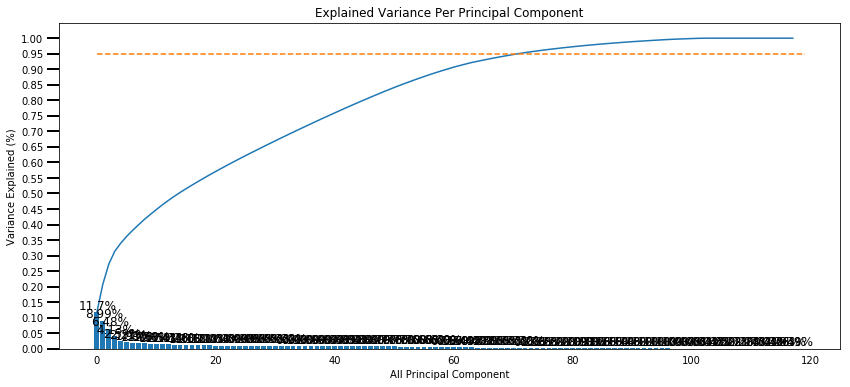

In [119]:
plot_var_bar_acum(pca_aza) # all components #pick 95% of overall variance => about 70 eigen vector

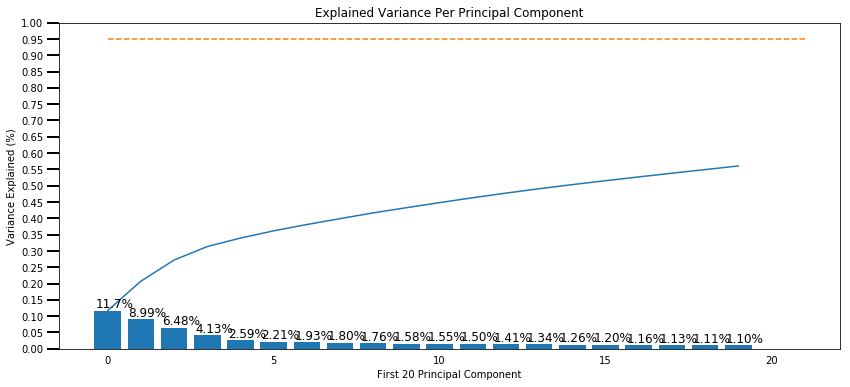

In [118]:
plot_var_bar_acum_2(pca_aza) # plots first 20 Princial components

In [121]:
#import matplotlib.lines as lines
def plot_var_bar_acum(pca):



    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    t1 = np.arange(0.0, float(num_components+2), 1)
    t2=np.array([0.95]*(num_components+2))

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.plot(t1,t2,'--')
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    plt.yticks(np.arange(0,1.05, 0.05))
    #plt.plot((0,0.95),(100,0.95))

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.show()

In [117]:
# Investigate the variance accounted for by each principal component.
#import matplotlib.lines as lines
def plot_var_bar_acum_2(pca):

    num_components=20   #len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_[0:num_components]
    
    t1 = np.arange(0.0, float(num_components+2), 1)
    t2=np.array([0.95]*(num_components+2))

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.plot(t1,t2,'--')
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    plt.yticks(np.arange(0,1.05, 0.05))
    #plt.plot((0,0.95),(100,0.95))

    ax.set_xlabel("First 20 Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.show()


In [191]:
# Re-apply PCA to the data while selecting for number of components to retain.

#chose n_component=70 since 95% of cumulative sum of variance ratio was reached

pca_aza_70 = PCA(n_components=70)
azdias_no_miss_encoded_scaled_pca=pca_aza_70.fit_transform(azdias_no_miss_encoded_scaled_df)

In [130]:
azdias_no_miss_encoded_scaled_pca=pca_aza_70.fit_transform(azdias_no_miss_encoded_scaled_df)  #get transformed data into 70 feature

In [131]:
np.isnan(azdias_no_miss_encoded_scaled_pca).sum()  #clean

0

In [132]:
azdias_no_miss_encoded_scaled_pca.shape

(623209, 70)

In [195]:
azdias_no_miss_encoded_scaled_pca[0:10,0:10]

array([[-5.08101785,  1.79871859, -3.24453724,  0.33721807, -1.4118377 ,
         0.11990908, -0.89110758, -3.99187448,  0.39705128,  2.19988991],
       [ 0.59879995,  0.80453976, -3.75480278,  2.61798016, -2.10185611,
        -1.44486911,  1.09179801, -0.96455993, -1.13887123, -0.81931064],
       [-0.22100852, -0.08981615,  3.25302979,  0.24190944,  0.62944392,
         3.1838481 , -1.40487173, -0.52691433, -0.80558047, -4.51548618],
       [ 0.53547598,  1.09045621, -1.32783918, -2.468594  , -3.55279685,
        -0.25320465,  0.78980718, -0.39284223,  0.25699237, -0.38106245],
       [-1.5927972 ,  3.38462562, -3.76521512, -0.91350425, -1.79677312,
        -1.22506093, -0.18848967,  1.12764004,  0.3992466 , -0.77452083],
       [ 0.75324874,  3.74588125,  4.14626097,  0.45702494, -2.28218362,
        -2.06020099, -0.82183401,  0.66726262,  0.3261091 ,  1.04212207],
       [ 2.64871703,  0.70866933,  1.7002533 ,  3.25933668,  0.42944519,
         0.22215293,  3.08466886, -0.09256452

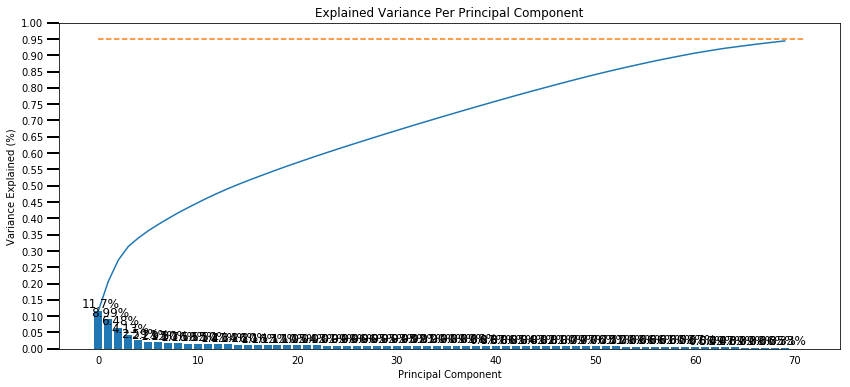

In [122]:
plot_var_bar_acum(pca_aza_70)   #first 70 components, at 95% acummlative variance ratio

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Plan to use 70 component/eigen vector out of 118 original feature (40% drop from original number with least impact on variance). This keep cumulative sum of variance ratio at 95%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [123]:

pca_aza_70.components_.shape

(70, 118)

In [124]:

# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

map_feature=azdias_no_miss_encoded_scaled_df.columns
def print_ith_weight_feature(feature_i,pca,map_feature):
    #pca_aza_60.explained_variance_ratio_[feature_i]
    feature_i=feature_i-1 #to give as index
    list_eigenvec0_unsorted=pca.components_[feature_i]
    list_eigenvec0_sorted_index_r = np.argsort(list_eigenvec0_unsorted)
    list_eigenvec0_sorted_index=np.array(list_eigenvec0_sorted_index_r[::-1])
    for index_ in list_eigenvec0_sorted_index:
        print(map_feature[index_],'   ',round(list_eigenvec0_unsorted[index_],2))
    
    

In [125]:
print_ith_weight_feature(1,pca_aza_70,map_feature) 
#positive: older, less minimalist, prepared enviromental consious, top earner 
#negative weight low income earners, from multiple matrix same direcction, high share of family homes (denser regions)

FINANZ_MINIMALIST     0.21
MOBI_REGIO     0.2
KBA05_ANTG1     0.19
PLZ8_ANTG1     0.18
KBA05_GBZ     0.18
ALTERSKATEGORIE_GROB     0.15
FINANZ_VORSORGER     0.14
PLZ8_GBZ     0.13
LP_STATUS_GROB_5     0.13
KONSUMNAEHE     0.12
GREEN_AVANTGARDE_1     0.12
youth_movement     0.12
INNENSTADT     0.12
CAMEO_family     0.11
SEMIO_LUST     0.11
FINANZTYP_2     0.1
LP_STATUS_GROB_4     0.1
SEMIO_ERL     0.1
BALLRAUM     0.09
GEBAEUDETYP_RASTER     0.09
ZABEOTYP_1     0.09
CAMEO_DEUG_2015_2     0.08
NATIONALITAET_KZ_1     0.08
CJT_GESAMTTYP_2     0.07
WOHNDAUER_2008     0.07
CAMEO_DEUG_2015_4     0.07
ZABEOTYP_3     0.06
KBA13_ANZAHL_PKW     0.06
CAMEO_DEUG_2015_3     0.06
LP_FAMILIE_GROB_5     0.05
OST_WEST_KZ_1     0.05
GFK_URLAUBERTYP_7     0.05
CAMEO_DEUG_2015_1     0.05
SHOPPER_TYP_3     0.05
RETOURTYP_BK_S     0.05
ZABEOTYP_2     0.04
FINANZTYP_6     0.04
LP_FAMILIE_GROB_2     0.04
GFK_URLAUBERTYP_6     0.03
SEMIO_VERT     0.03
FINANZTYP_3     0.03
CJT_GESAMTTYP_1     0.03
LP_STATUS_GROB

In [126]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_ith_weight_feature(2,pca_aza_70,map_feature) 
#positive weight youger,(religouos dutiful,traditional), like being online
#negative weightm older,fair_supplied, be_prepared, low to minimum returner, 

SEMIO_REL     0.21
youth_decade     0.21
FINANZ_UNAUFFAELLIGER     0.19
SEMIO_PFLICHT     0.19
SEMIO_TRADV     0.19
FINANZ_SPARER     0.18
SEMIO_KULT     0.18
ONLINE_AFFINITAET     0.16
FINANZ_ANLEGER     0.16
SEMIO_FAM     0.15
SEMIO_RAT     0.13
MOBI_REGIO     0.12
PLZ8_ANTG1     0.12
SEMIO_MAT     0.12
KBA05_GBZ     0.11
KBA05_ANTG1     0.11
ZABEOTYP_1     0.1
PLZ8_GBZ     0.09
FINANZTYP_4     0.09
ZABEOTYP_4     0.09
FINANZTYP_1     0.09
FINANZTYP_3     0.09
SEMIO_SOZ     0.09
INNENSTADT     0.08
ANREDE_KZ_1     0.08
KONSUMNAEHE     0.08
SHOPPER_TYP_0     0.07
SEMIO_VERT     0.07
ZABEOTYP_5     0.07
LP_FAMILIE_GROB_4     0.06
BALLRAUM     0.06
GFK_URLAUBERTYP_9     0.06
CAMEO_DEUG_2015_4     0.05
LP_FAMILIE_GROB_5     0.05
GREEN_AVANTGARDE_1     0.05
youth_movement     0.05
CJT_GESAMTTYP_4     0.05
GEBAEUDETYP_RASTER     0.05
CAMEO_DEUG_2015_2     0.05
KBA13_ANZAHL_PKW     0.05
OST_WEST_KZ_1     0.05
LP_STATUS_GROB_4     0.04
HEALTH_TYP     0.04
GFK_URLAUBERTYP_2     0.04
LP_STATUS

In [127]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_ith_weight_feature(3,pca_aza_70,map_feature) 
#positive  female,(dreamy, socially,culture, family minded),invest, number of the kids in the house
#negative male,(combative attitute,dominant minded,critical minded,ratioanl)

ANREDE_KZ_1     0.33
SEMIO_VERT     0.3
SEMIO_SOZ     0.24
SEMIO_FAM     0.23
SEMIO_KULT     0.21
FINANZTYP_5     0.14
FINANZ_MINIMALIST     0.12
SHOPPER_TYP_0     0.11
RETOURTYP_BK_S     0.1
W_KEIT_KIND_HH     0.09
ZABEOTYP_1     0.09
SEMIO_REL     0.08
FINANZ_VORSORGER     0.08
EWDICHTE     0.07
ORTSGR_KLS9     0.07
PLZ8_ANTG3     0.06
PLZ8_ANTG4     0.06
ALTERSKATEGORIE_GROB     0.06
SEMIO_MAT     0.05
SEMIO_LUST     0.05
ZABEOTYP_6     0.05
ARBEIT     0.04
PLZ8_ANTG2     0.04
youth_movement     0.04
GREEN_AVANTGARDE_1     0.04
CAMEO_wealth     0.04
RELAT_AB     0.04
SHOPPER_TYP_1     0.04
GFK_URLAUBERTYP_4     0.04
KBA05_ANTG4     0.04
CAMEO_DEUG_2015_9     0.03
VERS_TYP_2     0.03
CJT_GESAMTTYP_1     0.03
LP_STATUS_GROB_5     0.03
LP_FAMILIE_GROB_2     0.03
WOHNDAUER_2008     0.02
CAMEO_DEUG_2015_8     0.02
LP_FAMILIE_GROB_1     0.02
NATIONALITAET_KZ_2     0.02
KBA05_ANTG3     0.02
LP_STATUS_GROB_3     0.02
OST_WEST_KZ_0     0.01
PLZ8_HHZ     0.01
GFK_URLAUBERTYP_5     0.01
CJT_GE

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## 1-First principal:

Mostly points toward age and wealth, young vs. old oppostive sign, wealthy vs. poor opposite

-**positive weight**: older (ALTERSKATEGORIE_GROB), less minimalist (FINANZ_MINIMALIST), prepared enviromentally consious, top earner (LP_STATUS_GROB 5)<br>
-**negative weight**: low income earners, from multiple matrix columns also show same direction (LP_STATUS_GROB 1,HH_EINKOMMEN_SCORE,CAMEO_wealth, FINANZTYP_1) , high share of family homes,denser regions (PLZ8_ANTG3)
<br>
The trend in terms of columns low income gathered at one side (negative weight), column indicting wealth at positive weight. Age wise column indicting old-age at postive and indicating young age at negative. a note that age has (ALTERSKATEGORIE_GROB) col. higher means older, and also (youth_decade) which high value means younger. FINANZ_MINIMALIST higher value means less minimalist (double negative)

## 2-Second principal:

Mostly points toward age and charater, character like older/young again opposite direction, being dutiful/religous may indicate same trend, also on negative side, being prepared and fail supplied same direction

-**positive weight**: youger (youth decade), more similar trend of religous dutiful,traditional (SEMIO_ TRADV,PFLICHT)<br>
-**negative weightm**: older (ALTERSKATEGORIE_GROB),fair_supplied (ZABEOTYP_3), be_prepared (FINANZ VORSORGER), low to minimum returner<br>

## 3-Third principal:

This component points at gender and characteristics, being family oriented/social/cultural one side. and being dominant and combative other side of weight.

-**positive**:  female,dreamful, socially,culture, family minded (SEMIO_VERT/FAM/KULT),invest, number of the kids in the house<br>
-**negative**: male,combative attitute,dominant minded,critical minded (SEMIO_KAEM, SEMIO_DOM)<br>

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

1 1111036.93917
2 1010537.63528
3 950563.454208
4 919129.669884
5 890379.334555
6 871065.313386
7 850387.830248
8 835180.572946
9 823825.963589
10 812795.707842
11 805827.601677
12 798244.440634
13 792619.732593
14 786228.90493
15 781656.903828
16 777311.539057
17 772557.017668
18 768998.718892
19 764989.355656
20 760650.916382
21 756671.149605
22 754006.09686
23 749786.433762
24 748511.23842
25 744779.612291
26 741380.808392
27 738367.767462
28 736753.281218
29 732562.074971
30 730463.074439


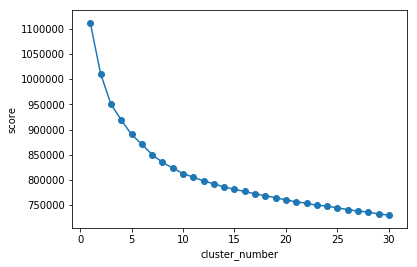

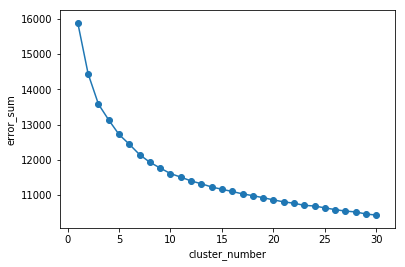

In [228]:
#for smaller set to test
cluster_test_data=azdias_no_miss_encoded_scaled_pca[0:10000,:]
KMean_fit_plot(cluster_test_data,30)

1 69413811.4148
2 63001894.1401
3 59376492.3048
4 57364179.8951
5 55599766.1022
6 54239822.9095
7 53086940.8071
8 52172585.4491
9 51467766.0975
10 50778916.1943
11 50271655.7437
12 49956053.8283
13 49537005.224
14 49151791.5525
15 48779302.9818
16 48527607.4059
17 48314135.5263
18 48078936.6564
19 47817301.3978
20 47599109.1755
21 47360158.3615
22 47174123.6626
23 46995950.2482
24 46796139.0328
25 46628034.9332
26 46408835.2565
27 46228062.8381
28 46128326.869
29 45866309.9588
30 45793051.5376


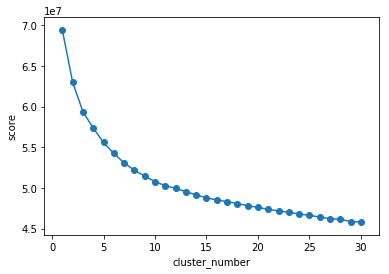

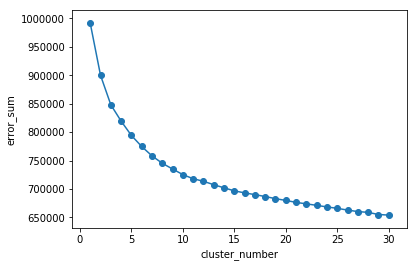

In [229]:
#for whole data
KMean_fit_plot(azdias_no_miss_encoded_scaled_pca,30)

In [230]:
#save pca model
#import pickle
filename1 = 'pca70_model.sav'
pickle.dump(pca_aza_70, open(filename1, 'wb'))
 


In [231]:
#refit for desired Cluster#
k_mean_30=KMeans(30)   #chose 30 cluster over 20 should have been ok
k_mean_30=k_mean_30.fit(azdias_no_miss_encoded_scaled_pca)
predictions_30 = k_mean_30.predict(azdias_no_miss_encoded_scaled_pca)

In [232]:
#save kmean model
#import pickle
filename2 = 'kmean30_model.sav'
pickle.dump(k_mean_30, open(filename2, 'wb'))   
 


In [234]:
pca_aza_70 = pickle.load(open(filename1, 'rb'))
k_mean_30 = pickle.load(open(filename2, 'rb'))

In [134]:
azdias_no_miss_encoded_scaled_pca=pca_aza_70.transform(azdias_no_miss_encoded_scaled_df)

In [176]:
predictions_30=k_mean_30.predict(azdias_no_miss_encoded_scaled_pca)

Text(0,0.5,'population per cluster')

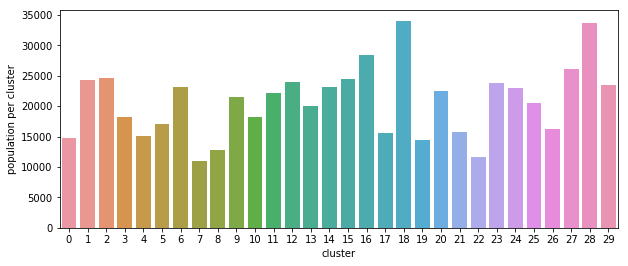

In [142]:
#general population per cluster
plt.figure(figsize=(10,4))
sns.countplot(predictions_30)

plt.xlabel('cluster')
plt.ylabel('population per cluster')

In [226]:
# Over a number of different cluster counts...


# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score,mean_squared_error
#cluster_test_data.shape
    # run k-means clustering on the data and...
def KMean_fit_plot(data,num_k):
    
    k_=[]
    score__=[]
    sum_error=[]
    silhouette_score=[]
    
    for i in range(num_k):

        k_mean=KMeans(i+1)
        k_mean=k_mean.fit(data)
        predictions = k_mean.predict(data)
        #print(predictions.shape,data.shape)
        #silhouette_avg = np.mean(np.array(silhouette_score(data, predictions)))
        #print(silhouette_avg.shape)
        cluster_cent = k_mean.cluster_centers_
        errors = [mean_squared_error(row, cluster_cent[cluster]) for row, cluster in zip(data, predictions)]
        error_sum=sum(errors)
        
        score_=np.abs(k_mean.score(data))
        print(i+1,score_)
        k_.append(i+1)
        score__.append(score_)
        #silhouette_score.append(silhouette_avg)
        sum_error.append(error_sum)

    plt.plot(k_,score__)   
    plt.scatter(k_,score__)   
    plt.ylabel('score')
    plt.xlabel('cluster_number')
    plt.show()
    
    #plt.plot(k_,silhouette_score)   
    #plt.scatter(k_,silhouette_score)   
    #plt.ylabel('silhouette score')
    #plt.xlabel('cluster_number')
    #plt.show()

    plt.plot(k_,sum_error)   
    plt.scatter(k_,sum_error) 
    plt.ylabel('error_sum')
    plt.xlabel('cluster_number')
    plt.show()
    
    
# predictions = kmeans.predict(data)
# silhouette_avg = silhouette_score(data, predictions)

# cluster_centers = kmeans.cluster_centers_
# errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]

# sum(errors)
    # compute the average within-cluster distances.
    
    

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Modeled the general population data up to 30 cluster. It was very time consuming the more csuter was added (5-7 min) per cluster. The error or absolute score both showed the more cluster added, population has on average less average squared distance difference from the center of their corrsponding cluster centroid (similar to MSE). After 20 cluster believe the # of cluster would be acceptable since the gain was minimal. I chose 30 cluster. Probably would be ok with 20 or 25 as well. There are variation in population size per cluster (Cluster 18 and 28 slightly has bigger population) but in genreal the population per cluster is between 2.5-5% of whole poulation, no unusual jump (see next section for % plot).


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [57]:
# Load in the customer demographics data.
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')  #sep=';'  error_bad_lines=False,

# Load in the feature summary file.
feat_info_customer = pd.read_csv('AZDIAS_Feature_Summary.csv',error_bad_lines=False, sep=';')

In [58]:
customer.shape

(191652, 85)

In [61]:
customer_no_miss_encoded_new=customer_clean_encode(customer,feat_info_customer) 

start converting to nan
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
finish converting to nan
drop outliers col
drop outliers row
write no miss data to file
make separate df of numeric col only
make separate df of categorical col only
write separate categorical file to csv
translate W/O
make one hot col list
try ANREDE_KZ
ANREDE_KZ [1.0, 2.0] 2
try CJT_GESAMTTYP
CJT_GESAMTTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 6
try FINANZTYP
FINANZTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 6
try GFK_URLAUBERTYP
GFK_URLAUBERTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0] 12
try GREEN_AVANTGARDE
GREEN_AVANTGARDE [0, 1] 2
try LP_FAMILIE_GROB
LP_FAMILIE_GROB [1.0, 2.0, 3.0, 4.0, 5.0] 5
try NATIONALITAET_KZ
NATIONALITAET_KZ [1.0, 2.0, 3.0] 3
try SHOPPER_TYP
SHOPPER_TYP [0.0, 1.0, 2.0, 3.0] 4
try VERS_TYP
VERS_TYP [1.0, 2.0] 2
try ZABEOTYP
ZABEOTYP [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 6
try OST_WEST_KZ
OST_WEST_KZ [0.0, 1.0] 2
try CAMEO_DEUG_2015
CAMEO_DEUG_2015 ['1', '2', '3', '4', '5', '6', '7', '8', 

In [62]:
customer_no_miss_encoded_new.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEUG_2015_9,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,LP_STATUS_GROB_4,LP_STATUS_GROB_5,youth_decade,youth_movement,CAMEO_wealth,CAMEO_family
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,4.0
4,3.0,3.0,1.0,4.0,4.0,5.0,2.0,3.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0
5,3.0,5.0,1.0,5.0,1.0,2.0,3.0,3.0,3.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,4.0
6,4.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0


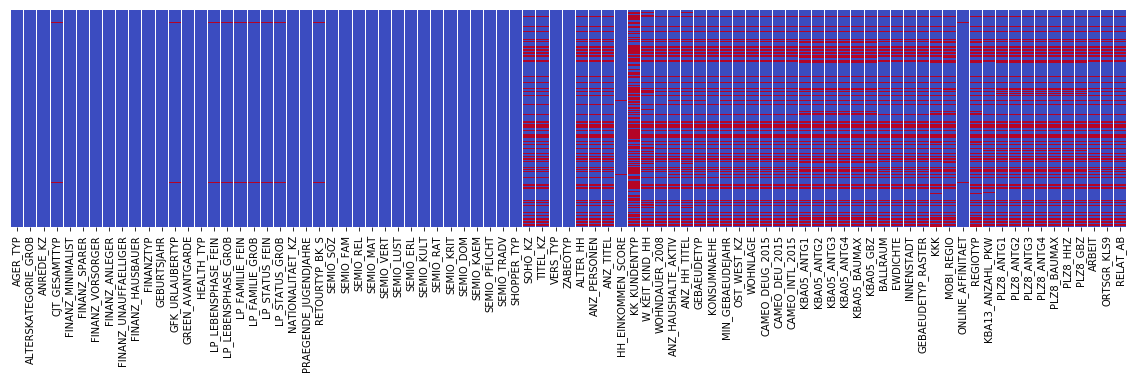

In [63]:
#original customer data
plt.figure(figsize=(20,4))
sns.heatmap(customer.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

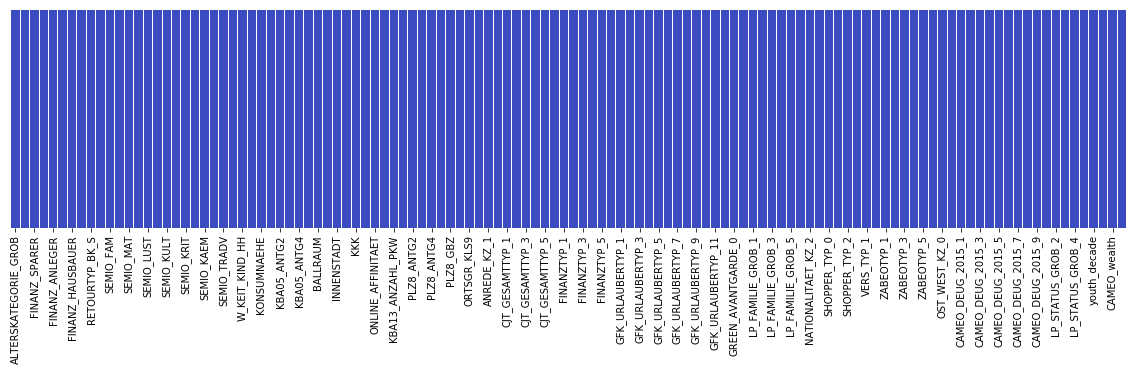

In [64]:
# customer data cleaned, encoded
plt.figure(figsize=(20,4))
sns.heatmap(customer_no_miss_encoded_new.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

In [66]:
print(azdias_no_miss_encoded_new.isnull().sum().sum())
print(customer_no_miss_encoded_new.isnull().sum().sum())
print(azdias_no_miss_encoded_new.shape)
print(customer_no_miss_encoded_new.shape)

0
0
(623209, 118)
(69969, 118)


In [68]:
customer_no_miss_encoded_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69969 entries, 0 to 115640
Columns: 118 entries, ALTERSKATEGORIE_GROB to CAMEO_family
dtypes: float64(118)
memory usage: 63.5 MB


In [129]:
#load models

filename1 = 'pca70_model.sav'
filename2 = 'kmean30_model.sav'
filename__ = 'standard_scaler_model.sav'


pca_aza_70 = pickle.load(open(filename1, 'rb'))
k_mean_30 = pickle.load(open(filename2, 'rb'))
scaler_aza = pickle.load(open(filename__, 'rb'))

In [79]:
#standard scaler transform

customer_no_miss_encoded_scaled=scaler_aza.transform(customer_no_miss_encoded_new)

In [86]:
customer_no_miss_encoded_scaled.shape

(69969, 118)

In [87]:
col_name=azdias_no_miss_encoded_new.columns
customer_no_miss_encoded_scaled_df=pd.DataFrame(customer_no_miss_encoded_scaled,columns=col_name)

In [88]:
print(azdias_no_miss_encoded_scaled_df.isnull().sum().sum(),customer_no_miss_encoded_scaled_df.isnull().sum().sum())

0 0


In [ ]:
customer_no_miss_encoded_scaled_df.to_csv('customer_no_miss_encoded_scaled_df.csv',index=False)   #write to file


In [95]:
customer_no_miss_encoded_scaled_df=pd.read_csv('customer_no_miss_encoded_scaled_df.csv')

In [94]:
#customer_no_miss_encoded_scaled_df.describe().loc['max']

In [96]:
customer_no_miss_encoded_scaled_df.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEUG_2015_9,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,LP_STATUS_GROB_4,LP_STATUS_GROB_5,youth_decade,youth_movement,CAMEO_wealth,CAMEO_family
count,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,...,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000,69969.000000
mean,0.720778,0.902359,-0.873646,0.824476,-0.842477,-0.559111,-0.291251,-0.333780,0.342084,0.084249,...,-0.279727,-0.564162,-0.182819,0.327442,0.095321,0.688066,-1.012732,0.699804,-0.457176,0.347781
std,0.658116,0.737031,0.540242,0.589364,0.660259,0.676513,0.946018,1.008017,0.815330,0.826720,...,0.584438,0.692316,0.844631,1.500936,1.074873,1.369524,0.906678,1.177612,0.955338,0.892569
min,-1.746291,-1.512224,-1.141401,-1.765051,-1.221857,-1.139028,-1.588887,-1.591638,-1.665690,-1.660648,...,-0.403596,-0.836562,-0.523893,-0.228226,-0.458083,-0.420057,-2.280180,-0.553670,-1.621368,-1.251108
25%,0.202107,0.692406,-1.141401,0.394976,-1.221857,-1.139028,-0.856545,-1.591638,-0.290654,-0.636130,...,-0.403596,-0.836562,-0.523893,-0.228226,-0.458083,-0.420057,-1.591253,-0.553670,-0.943466,0.082845
50%,1.176307,1.427283,-1.141401,1.114984,-1.221857,-0.410328,-0.856545,-0.273496,0.396864,-0.123872,...,-0.403596,-0.836562,-0.523893,-0.228226,-0.458083,-0.420057,-0.902326,1.806129,-0.943466,0.749822
75%,1.176307,1.427283,-0.460787,1.114984,-0.531628,-0.410328,0.608140,1.044647,1.084382,0.900646,...,-0.403596,-0.836562,-0.523893,-0.228226,-0.458083,2.380631,-0.213400,1.806129,0.412337,0.749822
max,1.176307,1.427283,1.581058,1.114984,1.539058,1.775773,1.340482,1.044647,1.084382,1.412904,...,2.477724,1.195369,1.908787,4.381626,2.183012,2.380631,1.164454,1.806129,1.768140,1.416798


In [97]:
customer_no_miss_encoded_scaled_df_pca=pca_aza_70.transform(customer_no_miss_encoded_scaled_df)

In [98]:
customer_no_miss_encoded_scaled_df_pca.shape

(69969, 70)

In [143]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#kmean predict

predictions_30_customer=k_mean_30.predict(customer_no_miss_encoded_scaled_df_pca)

In [144]:
predictions_30_customer.shape

(69969,)

Text(0,0.5,'population per cluster')

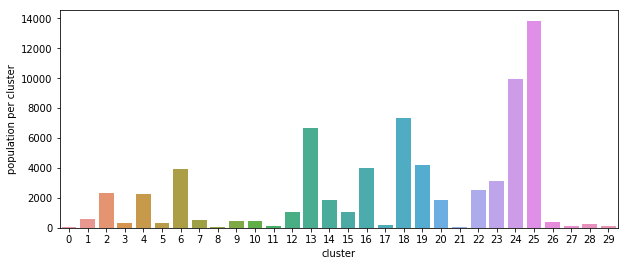

In [145]:
#customer population per cluster

plt.figure(figsize=(10,4))
sns.countplot(predictions_30_customer)

plt.xlabel('cluster')
plt.ylabel('population per cluster')

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [257]:
np.unique(predictions_30)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

In [265]:
predictions_30.shape

(623209,)

In [158]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
#predictions_30_customer
#predictions_30
n_cluster=30
size_general=predictions_30.shape[0]
size_customer=predictions_30_customer.shape[0]

percent_per_cluster_g=[]
percent_per_cluster_c=[]
k_=[]
ratio_percent_customer_general=[]

for i in range(n_cluster):
    
    check_g=np.array([i]*size_general)
    percent_30_g=sum((predictions_30)==check_g)/size_general
    
    check_c=np.array([i]*size_customer)
    percent_30_c=sum((predictions_30_customer)==check_c)/size_customer
    a=percent_30_c/percent_30_g
    percent_per_cluster_g.append(percent_30_g*100.0)
    percent_per_cluster_c.append(percent_30_c*100.0)
    ratio_percent_customer_general.append(a)
    k_.append(i)
    
    

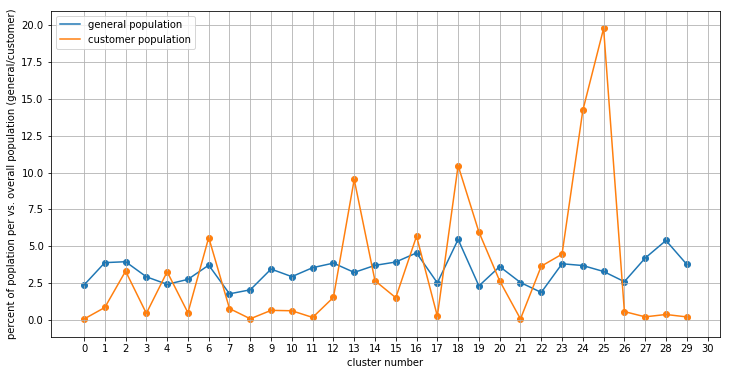

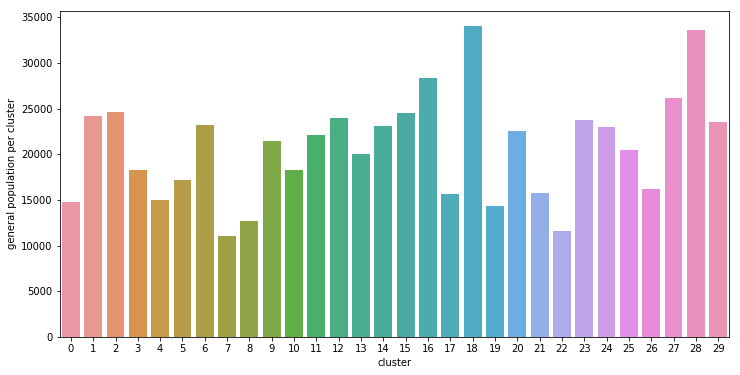

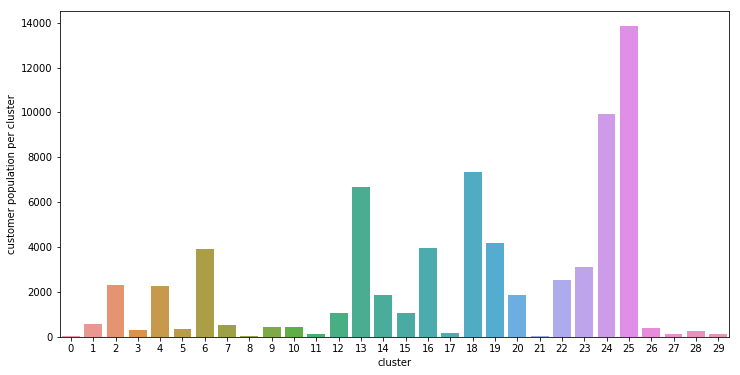

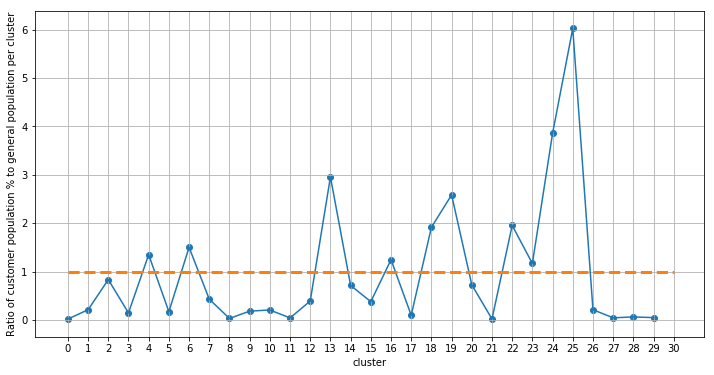

In [164]:
plt.figure(figsize=(12,6))
plt.plot(k_,percent_per_cluster_g,label='general population')
plt.scatter(k_,percent_per_cluster_g)
plt.plot(k_,percent_per_cluster_c,label='customer population')
plt.scatter(k_,percent_per_cluster_c)
plt.legend()
plt.xticks(np.arange(0,31,1))
plt.xlabel('cluster number')
plt.ylabel('percent of poplation per vs. overall population (general/customer)')
plt.grid(True)
plt.show()

predictions_30_customer
plt.figure(figsize=(12,6))
sns.countplot(predictions_30)

plt.xlabel('cluster')
plt.ylabel('general population per cluster')
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(predictions_30_customer)

plt.xlabel('cluster')
plt.ylabel('customer population per cluster')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(k_,ratio_percent_customer_general)
plt.scatter(k_,ratio_percent_customer_general)
t1 = np.arange(0.0, float(30+1), 1)
t2=np.array([1.0]*(30+1))
plt.plot(t1,t2,'--',linewidth=3)

plt.xticks(np.arange(0,31,1))
plt.xlabel('cluster')
plt.ylabel('Ratio of customer population % to general population per cluster')
plt.grid(True)
plt.show()

In [185]:

#cluster_centers_ : array, [n_clusters, n_features]
k_mean_30.cluster_centers_.shape


#25   24
#12   15

center_c24=k_mean_30.cluster_centers_[24]
center_c25=k_mean_30.cluster_centers_[25]

center_c12=k_mean_30.cluster_centers_[12]
center_c15=k_mean_30.cluster_centers_[15]

print(center_c24.shape,center_c25.shape,center_c12.shape,center_c15.shape)

(70,) (70,) (70,) (70,)


In [186]:
#inverse transform  PCA  pca_aza_70
center_c24_pca_inv=pca_aza_70.inverse_transform(center_c24)
center_c25_pca_inv=pca_aza_70.inverse_transform(center_c25)
center_c12_pca_inv=pca_aza_70.inverse_transform(center_c12)
center_c15_pca_inv=pca_aza_70.inverse_transform(center_c15)

print(center_c24_pca_inv.shape,center_c25_pca_inv.shape,center_c12_pca_inv.shape,center_c15_pca_inv.shape)

(118,) (118,) (118,) (118,)


In [187]:
#inverse transform  scaler  scaler_aza

center_c24_pca_scaler_inv=scaler_aza.inverse_transform(center_c24_pca_inv)
center_c25_pca_scaler_inv=scaler_aza.inverse_transform(center_c25_pca_inv)
center_c12_pca_scaler_inv=scaler_aza.inverse_transform(center_c12_pca_inv)
center_c15_pca_scaler_inv=scaler_aza.inverse_transform(center_c15_pca_inv)

print(center_c24_pca_scaler_inv.shape,center_c25_pca_scaler_inv.shape,center_c12_pca_scaler_inv.shape,center_c15_pca_scaler_inv.shape)

(118,) (118,) (118,) (118,)


In [189]:
map_feature=azdias_no_miss_encoded_scaled_df.columns
map_feature

Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       ...
       'CAMEO_DEUG_2015_9', 'LP_STATUS_GROB_1', 'LP_STATUS_GROB_2',
       'LP_STATUS_GROB_3', 'LP_STATUS_GROB_4', 'LP_STATUS_GROB_5',
       'youth_decade', 'youth_movement', 'CAMEO_wealth', 'CAMEO_family'],
      dtype='object', length=118)

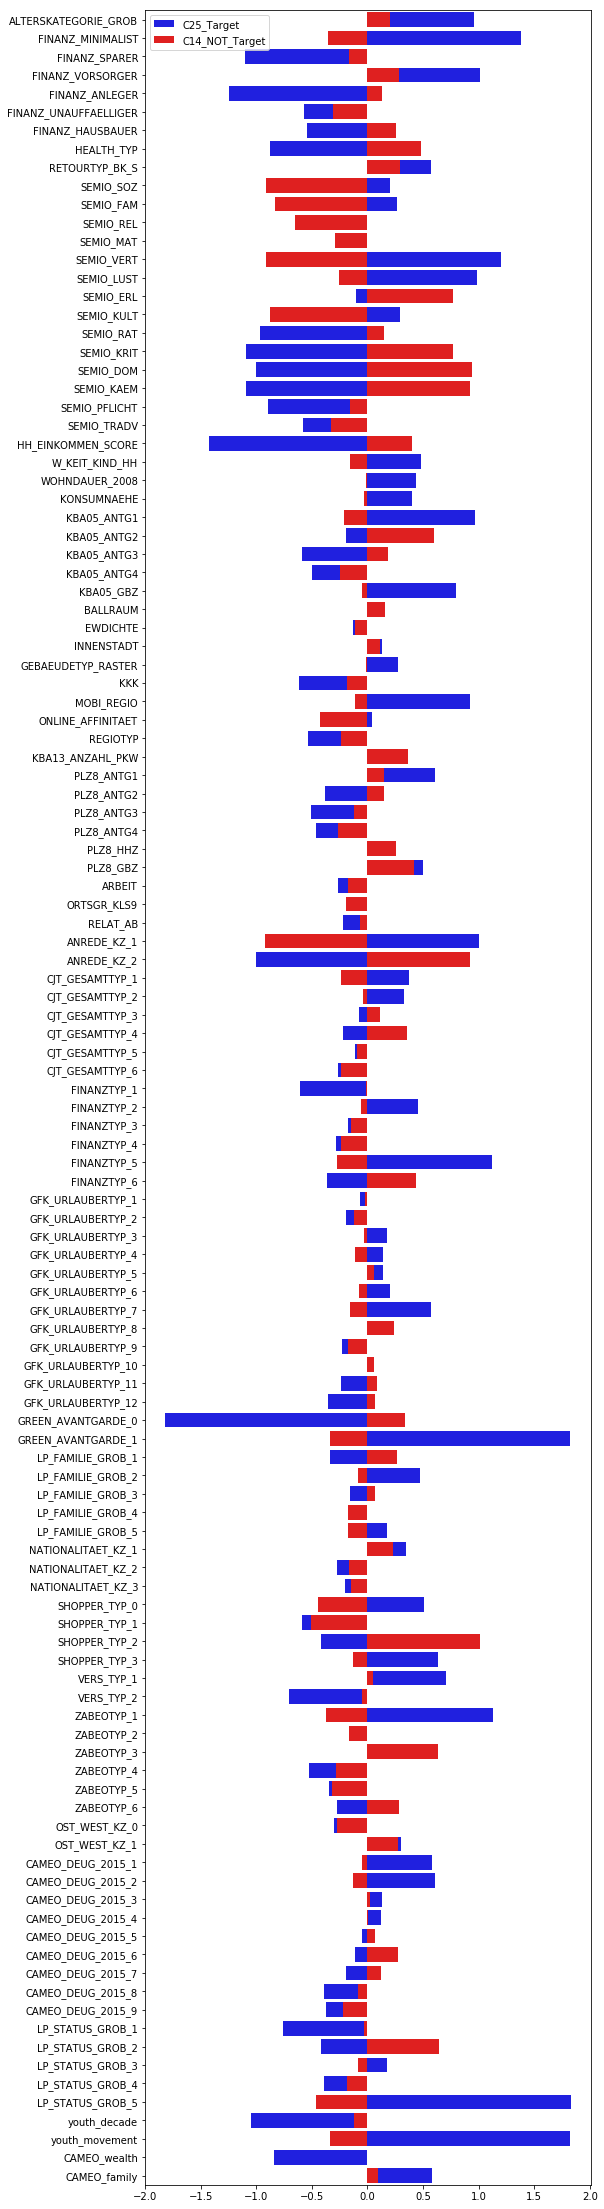

In [210]:
#comparing center C25 (good target) and center C15 (bad target), did not reverse the scaler since plotting won't be clear in actual unit

plt.figure(figsize=(8,40))

sns.barplot(x=center_c25_pca_inv, y=map_feature,label="C25_Target", color="blue")
sns.barplot(x=center_c15_pca_inv, y=map_feature,label="C15_NOT_Target", color="red")
          
plt.legend(loc="upper left")


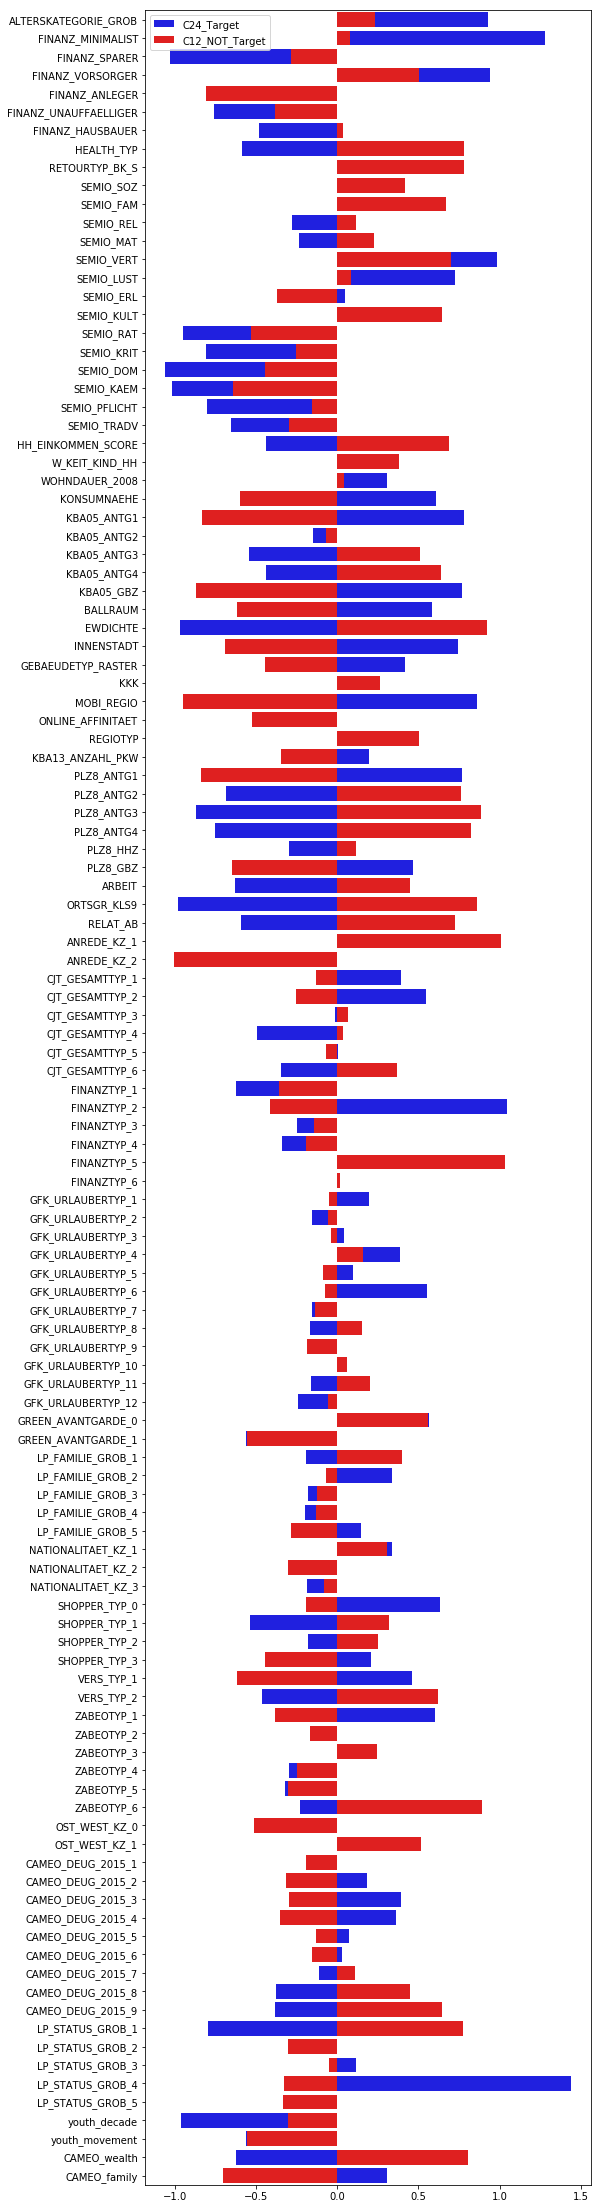

In [211]:

#comparing center C24 (good target) and center C12 (bad target), did not reverse the scaler since plotting won't be clear in actual unit

plt.figure(figsize=(8,40))

sns.barplot(x=center_c24_pca_inv, y=map_feature,label="C24_Target", color="blue")
sns.barplot(x=center_c12_pca_inv, y=map_feature,label="C12_NOT_Target", color="red")
          
plt.legend(loc="upper left")


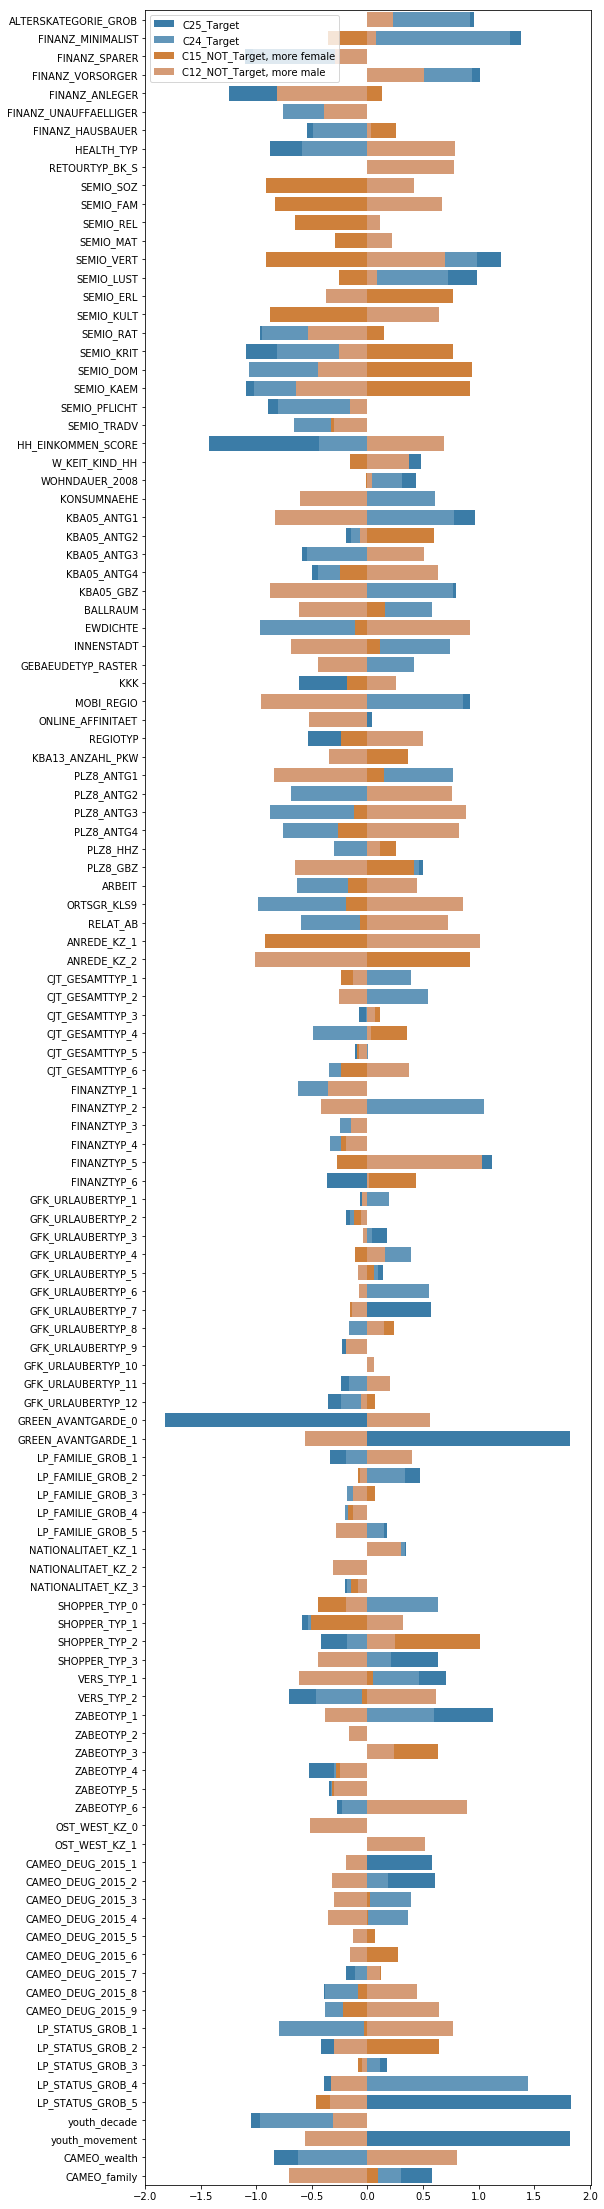

In [218]:
# What kinds of people are part of a cluster that is over represented underrepresented in the
# customer data compared to the general population?

plt.figure(figsize=(8,40))

sns.barplot(x=center_c25_pca_inv, y=map_feature,label="C25_Target", color="#2980B9")
sns.barplot(x=center_c24_pca_inv, y=map_feature,label="C24_Target", color="#5499C7")
sns.barplot(x=center_c15_pca_inv, y=map_feature,label="C15_NOT_Target, more female", color="#E67E22")
sns.barplot(x=center_c12_pca_inv, y=map_feature,label="C12_NOT_Target, more male", color="#E59866")         
plt.legend(loc="upper left")

#due to scale definition as high affinity to low affinity in may variabls, high in minimalist scale means not much minimalist
#older population (ALTERSKATEGORE), not minimalist (FINANZ_MINIMALIST), higher income bracket HH_EINKOMEN, low movement (MOBI_REGIO)
#higher number of building in micro cell KBA05_GBZ, not sentual minded ! SEMIO_LUST, further from urbal centers BALLRAUM, less dense area
#in term of household EWDICHTE, green energy consumption


# green energy

# more couple than single
# more demanding shopper SHOPPER_TYP
# more upper class to the consumption orientede middle class CAMEO_DEUG
# houe owners and top earners
# CAMEO_wealth wealthy
# cameo_family older

### Discussion 3.3: Compare Customer Data to Demographics Data


overall a threshold of 1.0 when ratio of customer to general population per cluster is calculated is considerd. If above 1.0 the cluster is target audience of mail-order. If below 1.0 is not. Since used 30 cluster, the customer data for some of the clusters had low population and eventhough they were below 1.0 threshold did not consider them for more detail look for principal components, due to statistical uncertainty. Using less cluster perhaps give bigger population per cell but with more cell I am picking up better signature of targeted group.<br>

**Good cluster for mail-order company: above 1.0 threshold <br>
good 4-6-13-18-19-22-24-25 **<br>

**Bad cluster for mail-order company: below 1.0 threshold <br>
bad 0-1-3-5-8-9-10-11-12-15-17-21-26-27-28-29**<br>

Among these two highest % of targeted group Cluster 24 and 25 (above 1 threshold), and two lower than threshold (below 1 threshold) Cluster 12 and C15.The C12 and C15 both were below 1.0 threshold and had more sample, so more reliable analysis.





## Popular with mail-order company: 

*Note: Due to large scale in some of the variable chose to not to reverse scale the standard scaler for better plotting. scale definition in many variables are high affinity to low affinity so more positive means low affinity, e.g. low affinifity in minimalist scale means not minimalist.


General trend : customers are older population (ALTERSKATEGORE), not minimalist (FINANZ_MINIMALIST), are in higher income bracket (HH_EINKOMEN), and low movement (MOBI_REGIO). They live further from urbal centers (BALLRAUM), and in less dense area
in term of household (EWDICHTE), area are more residential (GEBAEUDETYP). They are enviromently/enery consumption green. In the household there are more couple (LP_FAMILIE_GROB) than single and are more demanding shoppers (SHOPPER_TYP). In terms of class, they are more upper class to the consumption oriented middle (class CAMEO_DEUG). They are housee owners and top earners and wealthy (CAMEO_wealth), have high purchase power (KKK).Critical reserved (health type)


## Un-popular with mail-order company: 

Population is younger. They live in denser area of population (KONSUMNAEHE), have low income (EINKONEM_score), low purchase power (KKK), live closer to city center (INNENSTADT) in neighborhoods mixed with busineed area (GEBAEUDETYP). Live in area with high unemployment rate. They move more (mobi_regio). In terms of class they are middle to marginal class (REGIOTYP).

## Other interesting obsevations: 

women and male signature only showed up in not_target group (the two not target group looked at one was dominated by male C12 other one by female C14) 
The female group showed more family interest, dreamy!, and cultural oriented (SEMIO_SOZ, FAM, VERT), family shopper (SHOPPER TYP) and female group were more advertising interested Online-shopper (CJT_GESAMTTYP)

both target group (C24-C25) and not-target male group (C12) exhibit following trend than female cluster (C14)
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.